# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from IPython.display import Image
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [397]:
## Load the data into a DataFrame
df = pd.read_csv("/Users/peidacai/Downloads/Iowa_Liquor_Sales.csv")

df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.5,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.0,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.5,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.6,2.54
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.5,1.19


In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709552 entries, 0 to 2709551
Data columns (total 18 columns):
Date                     object
Store Number             int64
City                     object
Zip Code                 object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            int64
Item Number              int64
Item Description         object
Bottle Volume (ml)       int64
State Bottle Cost        object
State Bottle Retail      object
Bottles Sold             int64
Sale (Dollars)           object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtypes: float64(4), int64(5), object(9)
memory usage: 372.1+ MB


### Data Munging

In [473]:
df['Date'] = df['Date'].apply(pd.to_datetime)

In [399]:
# Function to convert money columns from string to float

def conv_money(x):
    x = x.split('.')
    return (float(x[0][1:]) + (float(x[1]) / 100))

In [400]:
# Converting columns with money value to float

df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]] = \
df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]].applymap(conv_money)

In [401]:
df['Item Description'] = df['Item Description'].apply(lambda x: x.strip())

In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709552 entries, 0 to 2709551
Data columns (total 18 columns):
Date                     object
Store Number             int64
City                     object
Zip Code                 object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            int64
Item Number              int64
Item Description         object
Bottle Volume (ml)       int64
State Bottle Cost        float64
State Bottle Retail      float64
Bottles Sold             int64
Sale (Dollars)           float64
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtypes: float64(7), int64(5), object(6)
memory usage: 372.1+ MB


## Cleaning Zipcodes

In [403]:
## Checking to see if all zipcodes have length of 5

df[df['Zip Code'].apply(lambda x: len(str(x)) != 5)]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


In [404]:
# Even when all is length 5, 1 entry was '712-2'
# Googled this, turned out to be area code, change to 51529

df[df['Zip Code'].apply(lambda x: x == '712-2')]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
28205,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1012100.0,CANADIAN WHISKIES,434,13037,Canadian Reserve Whisky,1000,5.31,7.97,4,31.88,4.00,1.06
28297,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031200.0,VODKA FLAVORED,380,41601,Uv Blue (raspberry) Vodka,375,3.45,5.18,4,20.72,1.50,0.40
28362,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1081200.0,CREAM LIQUEURS,260,68022,Bailey's Salted Caramel,750,12.50,18.75,1,18.75,0.75,0.20
28366,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1022100.0,TEQUILA,410,88296,Patron Tequila Silver,750,27.00,40.50,2,81.00,1.50,0.40
28387,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1022100.0,TEQUILA,85,3657,Herradura Gold Reposado 6pak,750,23.58,35.37,1,35.37,0.75,0.20
28407,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1081010.0,AMERICAN AMARETTO,55,73986,Di Amore Amaretto,750,6.00,9.00,4,36.00,3.00,0.79
28408,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031080.0,VODKA 80 PROOF,260,36186,Gordon's Vodka 80 Prf,750,5.26,7.89,4,31.56,3.00,0.79
28409,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1062300.0,FLAVORED RUM,65,44520,Cruzan Vanilla Rum,750,6.83,10.25,1,10.25,0.75,0.20
28410,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1032080.0,IMPORTED VODKA,370,34007,Absolut Swedish Vodka 80 Prf,1000,14.99,22.49,12,269.88,12.00,3.17
28411,03/28/2016,4307,DUNLAP,712-2,NaN,NaN,1031080.0,VODKA 80 PROOF,380,37348,Phillips Vodka,1750,7.60,11.40,6,68.40,10.50,2.77


In [405]:
# Changed erroneous zipcode

df.loc[df['Zip Code'] == '712-2', 'Zip Code'] = '51529'


In [406]:
# Changed zipcodes to int type

df['Zip Code'] = df['Zip Code'].apply(lambda x: int(x))

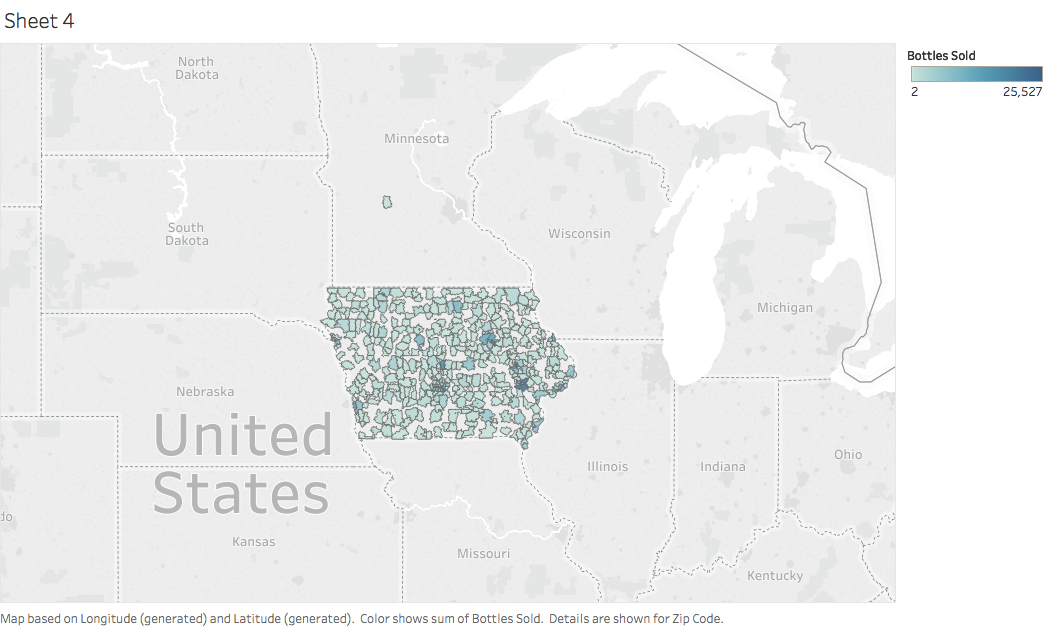

In [407]:
Image(filename='wrong_zip_des_moines.png')

In [408]:
# Correct Zip Code for Des Moines, Burlington

df.loc[df['Zip Code'] == 56201, 'Zip Code'] = 52601

## Cleaning City Values

In [409]:
list(df['City'].unique())

['DAVENPORT',
 'CEDAR FALLS',
 'DES MOINES',
 'WEST BRANCH',
 'WATERLOO',
 'ANKENY',
 'URBANDALE',
 'MASON CITY',
 'CORALVILLE',
 'JEFFERSON',
 'ELDRIDGE',
 'NORTHWOOD',
 'GRINNELL',
 'JOHNSTON',
 'CLEAR LAKE',
 'DENISON',
 'LAKE MILLS',
 'MADRID',
 'DEWITT',
 'MOUNT VERNON',
 'OSCEOLA',
 'NORTH LIBERTY',
 'WEST DES MOINES',
 'TIPTON',
 'CLINTON',
 'ROCKWELL',
 'LEON',
 'Des Moines',
 'PERRY',
 'LE CLAIRE',
 'NEW VIRGINIA',
 'MONROE',
 'LECLAIRE',
 'WILLIAMSBURG',
 'PRINCETON',
 'LAMONI',
 'CEDAR RAPIDS',
 'TIFFIN',
 'ST CHARLES',
 'NORWALK',
 'COLFAX',
 'Northwood',
 'CARROLL',
 'MANNING',
 'COON RAPIDS',
 'MANLY',
 'CAMANCHE',
 'GRAND JUNCTION',
 'AMES',
 'IOWA CITY',
 'STORM LAKE',
 'BETTENDORF',
 'NEVADA',
 'SIOUX CITY',
 'WINDSOR HEIGHTS',
 'CENTERVILLE',
 'OTTUMWA',
 'BOONE',
 'FORT ATKINSON',
 'PLEASANT HILL',
 'SERGEANT BLUFF',
 'MORAVIA',
 'FOREST CITY',
 'OELWEIN',
 'OTTUWMA',
 'MARENGO',
 'DECORAH',
 'PELLA',
 'MANSON',
 'ALTOONA',
 'ALBIA',
 'MAPLETON',
 'OSKALOOSA',
 'GOWR

In [410]:
# There are some 'City' entries which are in lower case while the majority is in Upper Case. 
# To prevent double counting, all "City" entries are changed to upper case

df['City'] = df['City'].apply(lambda x: x.upper())

## Cleaning NaN County entries

In [411]:
# Create a new dataframe for rows with NaNs in any cells

df_nan = df[pd.isnull(df).any(axis = 1)]

In [412]:
df_nan.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,12.50,18.75,6,112.50,4.50,1.19
114,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1011300.0,TENNESSEE WHISKIES,85,86670,Jack Daniel's Tennessee Honey,750,15.07,22.61,3,67.83,2.25,0.59
209,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081400.0,TRIPLE SEC,65,82606,Dekuyper Sour Apple Pucker,750,6.30,9.45,3,28.35,2.25,0.59
271,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,260,68034,Bailey's Original Irish Cream,375,7.00,10.50,3,31.50,1.12,0.30
288,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081600.0,WHISKEY LIQUEUR,421,64864,Fireball Cinnamon Whisky,375,5.33,8.00,6,48.00,2.25,0.59


In [413]:
# Printing columns that contain "NaN" and count the number of NaN entries per column

tbc_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        tbc_list.append(col)
        print col, x

County Number 10913
County 10913
Category 779
Category Name 6109


In [414]:
# Some counties and county numbers are not filled.
# Since "City" column does not contain NaN and Cities are a subset of counties,
# we try to see if there are similar cities with non-empty county values which we can then copy to the NaN county cells


# Create a set of Cities with NaN for county or county Number

city_nan_list = list(df_nan['City'].unique())

city_nan_list

['WEST BRANCH',
 'DES MOINES',
 'ROCKWELL',
 'CLINTON',
 'NORWALK',
 'MASON CITY',
 'DENISON',
 'CEDAR RAPIDS',
 'DAVENPORT',
 'SIOUX CITY',
 'WESLEY',
 'CORALVILLE',
 'SEYMOUR',
 'ALTOONA',
 'NORTH LIBERTY',
 'DUBUQUE',
 'CLARINDA',
 'BELMOND',
 'CRESCO',
 'WAVERLY',
 'FORT DODGE',
 'LARCHWOOD',
 'DUNLAP',
 'HARLAN',
 'SIGOURNEY',
 'HAMPTON',
 'ANAMOSA',
 'ACKLEY',
 'WATERLOO',
 'ANTHON',
 'ATLANTIC',
 'EVANSDALE',
 'CEDAR FALLS',
 'IOWA CITY',
 'CHARITON',
 'AMES',
 'TABOR',
 'AUDUBON',
 'PLEASANTVILLE',
 'RUNNELLS',
 'WEST LIBERTY',
 'OSCEOLA',
 'WAUKEE',
 'MUSCATINE',
 'BURLINGTON',
 'NEWTON',
 'COUNCIL BLUFFS',
 'WEST DES MOINES',
 'INDIANOLA',
 'MARION',
 'INDEPENDENCE',
 'MOUNT PLEASANT',
 'WEST POINT',
 'RIVERSIDE',
 'MOUNT VERNON',
 'KEOKUK',
 'BETTENDORF',
 'FAIRFIELD',
 'IOWA FALLS',
 'CARTER LAKE',
 'LISBON',
 'HIAWATHA',
 'MAQUOKETA',
 'COLUMBUS JUNCTION',
 'MISSOURI VALLEY',
 'WASHINGTON',
 'WELLMAN',
 'LATIMER',
 'ANITA',
 'BONDURANT',
 'ELDORA',
 'FORT MADISON',
 'URBAN

In [415]:
# Creating a dictionary with "City" as key and collecting all possible corresponding "County" and "County Name"
# as values of the dictionary

nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County'] if x > 0} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number'] if x > 0}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'ACKLEY': [['Webster', 'Hardin'], [42.0, 94.0]],
 'ADAIR': [['Adair'], [1.0]],
 'ADEL': [['Dallas'], [25.0]],
 'ALBIA': [['Monroe'], [68.0]],
 'ALDEN': [['Hardin'], [42.0]],
 'ALGONA': [['Kossuth'], [55.0]],
 'ALTOONA': [['Polk'], [77.0]],
 'AMES': [['Story'], [85.0]],
 'ANAMOSA': [['Jones'], [53.0]],
 'ANITA': [['Cass'], [15.0]],
 'ANKENY': [['Polk'], [77.0]],
 'ANTHON': [['Woodbury'], [97.0]],
 'ARNOLDS PARK': [['Dickinson'], [30.0]],
 'ATLANTIC': [['Cass'], [15.0]],
 'AUDUBON': [['Audubon'], [5.0]],
 'AVOCA': [['Pottawattamie'], [78.0]],
 'BANCROFT': [['Kossuth'], [55.0]],
 'BEDFORD': [['Taylor'], [87.0]],
 'BELLE PLAINE': [['Benton'], [6.0]],
 'BELLEVUE': [['Jackson'], [49.0]],
 'BELMOND': [['Wright'], [99.0]],
 'BETTENDORF': [['Iowa', 'Scott'], [48.0, 82.0]],
 'BLOOMFIELD': [['Davis'], [26.0]],
 'BLUE GRASS': [['Scott'], [82.0]],
 'BONDURANT': [['Polk'], [77.0]],
 'BOONE': [['Boone'], [8.0]],
 'BURLINGTON': [['Des Moines'], [29.0]],
 'CAMBRIDGE': [['Polk'], [77.0]],
 'CARLISLE': 

In [443]:
## Replacing NaN county cells using corresponding city value as key

for cty in nan_cty_dict:
    
    if len(nan_cty_dict[cty][0]) >1:
        df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][1]
        df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][1]
        
    else:
        try:
            df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][0]
            df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][0]
        except:
            pass

In [446]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df[['County','County Number']]).any(axis = 1)]

In [448]:
# Collect cities with NaN values
city_nan_list = list(df_nan['City'].unique())

city_nan_list

['SEYMOUR', 'TABOR', 'RUNNELLS']

In [449]:
nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County']} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number']}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

{'RUNNELLS': [[nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]],
 'SEYMOUR': [[nan],
  [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   na

In [450]:
# Updating counties by hand

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'

In [451]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df['County'])]

In [452]:
len(df_nan)

0

#### Comments:

Remaining 12 rows with empty counties were filled manually. Without a reference of how county numbers were developed, we left the empty county numbers empty. Analyses based on counties will be performed on 'County' instead of 'County Number'.

# ---------------------------------------------------------------

## Cleaning Empty Category Name using Item Decription

In [454]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

6109


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
3638,03/31/2016,2595,DENISON,51442,24.0,Crawford,1082100.0,NaN,322,942899,Rondiaz Coconut Rum,1750,10.00,15.00,6,90.00,10.50,2.77
41883,03/24/2016,2515,MASON CITY,50401,17.0,Cerro Gordo,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
43771,03/24/2016,4648,WATERLOO,50703,7.0,Black Hawk,1092100.0,NaN,492,977576,Twenty Grand Gold,375,7.00,10.50,6,63.00,2.25,0.59
82854,03/17/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1091100.0,NaN,434,933934,Pearl Caramel,1000,8.67,13.01,24,312.24,24.00,6.34
88787,03/16/2016,2512,IOWA CITY,52240,52.0,Johnson,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
98331,03/16/2016,4129,AMES,50010,85.0,Story,1091100.0,NaN,448,932342,St. George Absinthe Verte,750,30.00,45.00,6,270.00,4.50,1.19
119563,03/14/2016,4829,DES MOINES,50314,77.0,Polk,1082100.0,NaN,434,968842,St. Brendan's Irish Cream Liqueur,1000,7.67,11.51,120,1381.20,120.00,31.70
155299,03/07/2016,4806,WEST LIBERTY,52776,70.0,Muscatine,NaN,NaN,410,989624,Patron Reposado,375,14.50,21.75,12,261.00,4.50,1.19
174624,03/02/2016,3869,CORALVILLE,52241,52.0,Johnson,1022200.0,NaN,300,903369,Hussong's Reposado Tequila 100% Agave,750,20.00,30.00,6,180.00,4.50,1.19
185782,03/01/2016,2665,WAUKEE,50263,25.0,Dallas,1082100.0,NaN,305,965074,Giffard Creme de Pamplemousse Rose Pink Grapef...,750,13.25,19.88,6,119.28,4.50,1.19


In [455]:
# Create a list of "Item Description" with NaN in rows
item_nan_list = list(df_nan['Item Description'].unique())

item_nan_list

['Rondiaz Coconut Rum',
 'Del Maguey San Luis Del Rio',
 'Twenty Grand Gold',
 'Pearl Caramel',
 'St. George Absinthe Verte',
 "St. Brendan's Irish Cream Liqueur",
 'Patron Reposado',
 "Hussong's Reposado Tequila 100% Agave",
 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',
 'Svedka Vodka',
 'Stolichnaya Premium Vodka 80 Prf',
 'Hennessy Vs Cognac',
 'Captain Morgan Pineapple',
 'Hennessy VS',
 'Blue Chair Bay Coconut',
 'Grand Marnier Cordon Rouge',
 'Il Tramonto Limoncello',
 'Licor 43',
 'American Born Moonshine Apple Pie',
 'Hennessy Vs Cognac 100ml',
 'Grand Marnier Raspberry Peach',
 'Belvedere Vodka',
 'Disaronno Amaretto',
 'Ole Smoky Apple Pie Moonshine',
 'Belvedere Intense Unfiltered',
 'Rondiaz Rum Spiced',
 "Tim Smith's Climax Moonshine",
 'Kraken Black Mini',
 'Ricura Mini',
 'Domaine de Canton',
 'Hennessy Black',
 'Letherbee Gin',
 'Hennessy VSOP Privilege',
 'Svedka',
 'Exotico Blanco',
 '1800 Silver',
 'Blue Chair Bay Coconut Spiced',
 'Olmeca Altos Repo

In [456]:
item_dict = {}

for j in item_nan_list:
    c_set = {x for x in df[df['Item Description']==j]['Category Name'] if x > 0}
    item_dict[j] = list(c_set)

item_dict

{'1800 Reposado': ['TEQUILA'],
 '1800 Silver': ['TEQUILA'],
 'Absolut Black 100': [],
 'Absolut Hibiskus': ['IMPORTED VODKA - MISC'],
 'Absolut w/Ginger Beer': [],
 'Alize Blue': [],
 'Alize Gold': [],
 'American Born Moonshine Apple Pie': ['DISTILLED SPIRITS SPECIALTY'],
 'American Born Moonshine Dixie': ['DISTILLED SPIRITS SPECIALTY'],
 'American Born Moonshine Original': ['DISTILLED SPIRITS SPECIALTY'],
 'Anchor Old Tom Gin': [],
 'Artisan Grain Original Moonshine': ['AMERICAN ALCOHOL',
  'DISTILLED SPIRITS SPECIALTY'],
 'Bacardi Oakheart': ['SPICED RUM'],
 'Belvedere Intense Unfiltered': ['IMPORTED VODKA'],
 'Belvedere Vodka': ['IMPORTED VODKA'],
 'Berentzen Apple': ['MISC. IMPORTED CORDIALS & LIQUEURS'],
 'Bird Dog Peppermint Moonshine': ['DISTILLED SPIRITS SPECIALTY'],
 'Blue Chair Bay Banana': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Blue Chair Bay Coconut Spiced': ['BARBADOS RUM', 'FLAVORED RUM'],
 'Bombay Sapphire w/Glass

In [457]:
for drink in item_dict:
    try:
        df.loc[df['Item Description'] == drink, 'Category Name'] = item_dict[drink][0]
    except:
        pass

In [458]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

539


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
3638,03/31/2016,2595,DENISON,51442,24.0,Crawford,1082100.0,NaN,322,942899,Rondiaz Coconut Rum,1750,10.00,15.00,6,90.00,10.50,2.77
41883,03/24/2016,2515,MASON CITY,50401,17.0,Cerro Gordo,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
43771,03/24/2016,4648,WATERLOO,50703,7.0,Black Hawk,1092100.0,NaN,492,977576,Twenty Grand Gold,375,7.00,10.50,6,63.00,2.25,0.59
82854,03/17/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1091100.0,NaN,434,933934,Pearl Caramel,1000,8.67,13.01,24,312.24,24.00,6.34
88787,03/16/2016,2512,IOWA CITY,52240,52.0,Johnson,1022300.0,NaN,330,989202,Del Maguey San Luis Del Rio,750,40.00,60.00,6,360.00,4.50,1.19
98331,03/16/2016,4129,AMES,50010,85.0,Story,1091100.0,NaN,448,932342,St. George Absinthe Verte,750,30.00,45.00,6,270.00,4.50,1.19
174624,03/02/2016,3869,CORALVILLE,52241,52.0,Johnson,1022200.0,NaN,300,903369,Hussong's Reposado Tequila 100% Agave,750,20.00,30.00,6,180.00,4.50,1.19
185782,03/01/2016,2665,WAUKEE,50263,25.0,Dallas,1082100.0,NaN,305,965074,Giffard Creme de Pamplemousse Rose Pink Grapef...,750,13.25,19.88,6,119.28,4.50,1.19
195605,02/29/2016,2506,BURLINGTON,52601,29.0,Des Moines,1062400.0,NaN,395,46502,Kraken Black Mini,750,10.75,16.13,1,16.13,0.75,0.20
200785,02/29/2016,2538,WATERLOO,50702,7.0,Black Hawk,1062400.0,NaN,395,46502,Kraken Black Mini,750,10.75,16.13,51,822.63,38.25,10.10


In [459]:
df_nan['Item Description'].unique()

array(['Rondiaz Coconut Rum', 'Del Maguey San Luis Del Rio',
       'Twenty Grand Gold', 'Pearl Caramel', 'St. George Absinthe Verte',
       "Hussong's Reposado Tequila 100% Agave",
       'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',
       'Kraken Black Mini', 'High Stick Vodka',
       "Dr. McGillicuddy's Mentholmint", 'Alize Blue', 'Alize Gold',
       'Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls',
       'Kahlua Mocha', 'The Kings Ginger',
       'Rothman & Winter Orchard Peach', 'Westland American Single Malt',
       'Westland Peated Single Malt', 'Westland Sherry Wood Single Malt',
       'Svedka Strawberry Lemonade Vodka',
       'Christian Drouin Calvados Selcetion', 'Anchor Old Tom Gin',
       'Karlssons Gold Vodka', 'Hudson New York Corn',
       'Tiramisu Italian Liqueur', 'Terry Centenario', 'Courvoisier Gold',
       'Calico Tropical Punch Jack Rum', 'Absolut w/Ginger Beer',
       'The Bitter Truth Apricot Liqueur',
       'The Bitter Tr

In [460]:
package = ['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls', \
           'Bombay Sapphire w/Glass', \
           'Evan Williams Egg Nog', \
           'Pinnacle Candy Cane Trial Pack', \
           'Wild Turkey American Honey Shot Tap', \
           'Knob Creek w/ Crystal Decanter' \
          ]

for i in package:
    
    df.loc[df['Item Description'] == i,'Category Name'] = 'DECANTERS & SPECIALTY PACKAGES'

In [461]:
df.loc[df['Item Description'] == 'Woodford Reserve MC 1838 White Corn',\
       'Category Name'] = 'CORN WHISKIES'

df.loc[df['Item Description'] == 'Hudson New York Corn',\
       'Category Name'] = 'CORN WHISKIES'

In [462]:
lique = ['Rothman & Winter Orchard Peach', \
         'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur', \
         'Pearl Caramel', \
         'Tiramisu Italian Liqueur', \
         'The Bitter Truth Apricot Liqueur', \
         'The Bitter Truth Violet Liqueur', \
         'Kahlua Mocha', \
         "Dr. McGillicuddy's Mentholmint", \
         'Alize Blue', \
         'The Kings Ginger', \
         'Courvoisier Gold', \
         'Grand Marnier Cuvee 1880 HA', \
         'Cocoyac Excellence' \
        ]

for i in lique:
    df.loc[df['Item Description'] == i,'Category Name'] ='MISC. IMPORTED CORDIALS & LIQUEURS'

In [463]:
scotch = ['Westland American Single Malt', \
          'Westland Peated Single Malt', \
          'Westland Sherry Wood Single Malt', \
          'Glenfiddich 1963 Replica HA' \
         ]

for s in scotch:
    
    df.loc[df['Item Description'] == s, \
           'Category Name' \
          ] ='SINGLE MALT SCOTCH'

In [464]:
df.loc[df['Item Description'] == 'Parkers Heritage Collection Malt Whiskey HA',\
       'Category Name'] = "STRAIGHT BOURBON WHISKIES"

df.loc[ \
       df[ \
          'Item Description' \
         ] == \
       'Chivas Regal 18YR Tin HA', \
       'Category Name' \
       ] = 'BLENDED WHISKIES'


In [465]:
vod = ['High Stick Vodka', \
       'Ciroc Ten HA', \
       'Ultimat Vodka', \
       'Karlssons Gold Vodka' \
      ]

for i in vod:
    
    df.loc[df['Item Description'] == i,'Category Name'] = 'IMPORTED VODKA'

df.loc[df['Item Description'] == 'Absolut Black 100', 'Category Name'] = '100 PROOF VODKA'

fvod = ['Van Gogh Rich Dark Chocolate Vodka', \
        'Absolut w/Ginger Beer', \
        'Van Gogh Chocolate Vodka', \
        'Svedka Strawberry Lemonade Vodka', \
        'Van Gogh Coconut', \
        'Alize Gold' \
       ]

for f in fvod:
    
    df.loc[df['Item Description'] == f, 'Category Name'] = 'VODKA FLAVORED'
    
    
df.loc[df['Item Description'] == 'Twenty Grand Gold',\
       'Category Name'] = 'VODKA 80 PROOF'

In [466]:
teq = ['Del Maguey San Luis Del Rio', \
       "Hussong's Reposado Tequila 100% Agave" \
      ]

for t in teq:
    
    df.loc[df['Item Description'] == t, 'Category Name'] = 'TEQUILA'

In [467]:
df.loc[df['Item Description'] == 'Kraken Black Mini', 'Category Name'] = 'SPICED RUM'

df.loc[df['Item Description'] == 'The Bitter Truth Pimento Dram', 'Category Name'] = 'JAMAICA RUM'



rum = ['Rondiaz Coconut Rum', 'Calico Tropical Punch Jack Rum' "Whaler's Original Dark Rum"]

for r in rum:
    
    df.loc[df['Item Description'] == r, 'Category Name'] = 'FLAVORED RUM'

In [468]:
df.loc[df['Item Description'] == 'St. George Absinthe Verte', 'Category Name'] = 'DISTILLED SPIRITS SPECIALTY'

In [469]:
brandy = ['Christian Drouin Calvados Selcetion',\
          'Terry Centenario' \
         ]

for b in brandy:
    df.loc[df['Item Description'] == b, 'Category Name'] = 'IMPORTED GRAPE BRANDIES'

In [470]:
df.loc[df['Item Description'] == 'Anchor Old Tom Gin', 'Category Name'] = 'AMERICAN DRY GINS'

In [471]:
df.loc[df['Item Description'] == 'Gamle Ode Celebration Aquavit', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

df.loc[df['Item Description'] == 'Gamle Ode Holiday', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

#### Comments:

There are still cells in 'Category' with NaN values, however, since we will only be using "Category Name" for analyses, NaNs in 'Category' were not cleaned.

## Exploring and Mining the data

### Creating new features

### Year

In [475]:
df['Sale Year'] = df['Date'].dt.year

### Month

In [476]:
df['Sale Month'] = df['Date'].dt.month

### Bottle Gross Profit

In [477]:
df['Bottle Gross Profit'] = df['State Bottle Retail'] - df['State Bottle Cost']

### Gross Profit

In [478]:
df['Gross Profit'] = df['Bottle Gross Profit'] * df['Bottles Sold']

In [479]:
df.head(2)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Sale Year,Sale Month,Bottle Gross Profit,Gross Profit
0,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,...,9.99,14.99,12,179.88,4.5,1.19,2016,3,5.00,60.0
1,2016-03-31,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,...,12.50,18.75,2,37.50,2.0,0.53,2016,3,6.25,12.5


### Splitting dataset by year to account for seasonality effect

In [480]:
# Creating a new df for 2015 and 2016 separately

# Used as training data
df_15 = df[df['Sale Year'] == 2015]

# Used as testing data
df_16 = df[df['Sale Year'] == 2016]

In [481]:
# Pivoting data frame based on county

county_15 = pd.pivot_table(df, \
                           index = ['County'], \
                           values = [\
                                     'State Bottle Retail', \
                                     'Bottles Sold', \
                                     'Sale (Dollars)', \
                                     'Gross Profit', \
                                     'Store Number' \
                                     ], \
                           aggfunc = [\
                                      np.sum, \
                                      np.mean, \
                                      pd.Series.nunique, \
                                      len \
                                     ] \
                           ).sort_values( \
                                         [('sum', \
                                           'Sale (Dollars)' \
                                           )], \
                                         ascending = False \
                                        )

county_15.reset_index(inplace=True)
county_15.head()

County          sum                                                   \
              Bottles Sold  Gross Profit Sale (Dollars) State Bottle Retail   
0        Polk      5129842  2.297811e+07   6.878998e+07        6.347803e+06   
1        Linn      2434575  1.035519e+07   3.098818e+07        3.365035e+06   
2       Scott      2089360  8.546427e+06   2.559399e+07        2.478171e+06   
3     Johnson      1539666  7.249179e+06   2.170096e+07        2.117267e+06   
4  Black Hawk      1739236  6.657844e+06   1.991899e+07        2.137939e+06   

                       mean                                                  \
  Store Number Bottles Sold Gross Profit Sale (Dollars) State Bottle Retail   
0   1498750568    12.380785    55.457259     166.023432           15.320312   
1    819857648    10.468859    44.528130     133.251539           14.469910   
2    623061127    12.190107    49.863052     149.324880           14.458576   
3    468403349    11.393540    53.643982     160.587262           15.667789   
4    559157605    11.494825    44.002511     131.647056           14.129901   

      ...           nunique                                                  \
      ...      Bottles Sold Gross Profit Sale (Dollars) State Bottle Retail   
0     ...               173       6749.0         7515.0              1345.0   
1     ...               152       5405.0         6019.0              1032.0   
2     ...               132       5054.0         5635.0               928.0   
3     ...               117       4796.0         5355.0              1026.0   
4     ...               132       4696.0         5277.0               966.0   

                        len                                                  \
  Store Number Bottles Sold Gross Profit Sale (Dollars) State Bottle Retail   
0          170       414339     414339.0       414339.0            414339.0   
1          104       232554     232554.0       232554.0            232554.0   
2           69       171398     171398.0       171398.0            171398.0   
3           56       135135     135135.0       135135.0            135135.0   
4           73       151306     151306.0       151306.0            151306.0   

                
  Store Number  
0       414339  
1       232554  
2       171398  
3       135135  
4       151306  

[5 rows x 21 columns]

In [482]:
df1 = df.copy()

In [483]:
len(df_15), len(df)

(2184483, 2709552)

In [484]:
df_15['Store Number'].count()

2184483

In [485]:
# Extracting relevant columns into a new df

county_15_new = pd.concat([county_15['County'], \
                           county_15[('sum', 'Sale (Dollars)')], \
                           county_15[('sum', 'Gross Profit')], \
                           county_15[('sum', 'Bottles Sold')], \
                           county_15[('mean', 'State Bottle Retail')], \
                           county_15[('nunique', 'Store Number')], \
                           county_15[('len', 'Bottles Sold')]], \
                          axis = 1)

county_15_new.columns = ['County', \
                         'Sum Sale',\
                         'Sum Gross Profit', \
                         'Sum Bottles Sold', \
                         "Avg Bottle Price", \
                         "Number of stores", \
                         "No. Trans" \
                        ]

county_15_new['Avg Bottle Price'] = county_15_new['Avg Bottle Price'].apply(lambda x: round(x, 2))

county_15_new.sort_values(['Sum Sale'], ascending = False, inplace=True)

county_15_new.head(10)

,County,Sum Sale,Sum Gross Profit,Sum Bottles Sold,Avg Bottle Price,Number of stores,No. Trans
0,Polk,6.878998e+07,2.297811e+07,5129842,15.32,170,414339
1,Linn,3.098818e+07,1.035519e+07,2434575,14.47,104,232554
2,Scott,2.559399e+07,8.546427e+06,2089360,14.46,69,171398
3,Johnson,2.170096e+07,7.249179e+06,1539666,15.67,56,135135
4,Black Hawk,1.991899e+07,6.657844e+06,1739236,14.13,73,151306
5,Dallas,1.674247e+07,5.596346e+06,1096279,15.32,58,108635
6,Woodbury,1.250641e+07,4.177702e+06,950205,14.97,39,86032
7,Pottawattamie,1.242305e+07,4.148367e+06,951506,14.17,53,91780
8,Dubuque,1.072651e+07,3.586643e+06,783894,15.00,41,76979
9,Story,1.059031e+07,3.541601e+06,770265,15.30,38,90284


In [486]:
county_15_new.describe()

,Sum Sale,Sum Gross Profit,Sum Bottles Sold,Avg Bottle Price,Number of stores,No. Trans
count,9.900000e+01,9.900000e+01,9.900000e+01,99.000000,99.000000,99.000000
mean,3.533888e+06,1.181349e+06,2.692690e+05,14.405859,14.171717,27369.212121
std,8.521156e+06,2.846492e+06,6.460896e+05,0.830307,22.967608,54386.984725
min,3.284335e+04,1.096948e+04,3.355000e+03,11.470000,1.000000,276.000000
25%,5.470660e+05,1.830150e+05,4.562500e+04,13.955000,5.000000,5759.000000
50%,1.003977e+06,3.362936e+05,7.731200e+04,14.500000,7.000000,10824.000000
75%,2.172444e+06,7.281522e+05,1.567320e+05,14.955000,12.000000,20402.000000
max,6.878998e+07,2.297811e+07,5.129842e+06,15.730000,170.000000,414339.000000


### Plotting total sale of each county for top 15 counties in descending sale

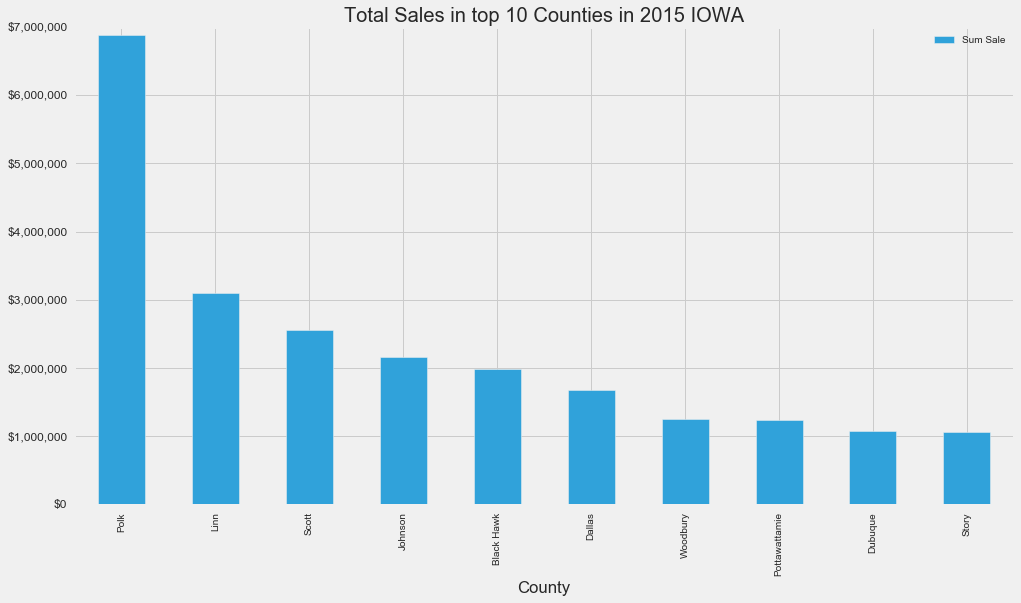

In [487]:
ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Sum Sale', figsize = (15,8))

ax.set_title('Total Sales in top 10 Counties in 2015 IOWA')
ax.set_xlabel('County')
ax.set_yticklabels(['$0', \
                    '$1,000,000', \
                    '$2,000,000', \
                    '$3,000,000', \
                    '$4,000,000', \
                    '$5,000,000', \
                    '$6,000,000', \
                    '$7,000,000', \
                    '$8,000,000'], \
                   fontsize = 12 \
                  )

plt.savefig('top10_counties_total_sales_bar.png');

#### Comments:

In 2015, Polk had, by far, the highest sales and profit (see below) in all counties in IOWA, over 2 times the next highest county, Linn.

### Plotting top 10 IOWA counties with highest Gross Profit in 2015

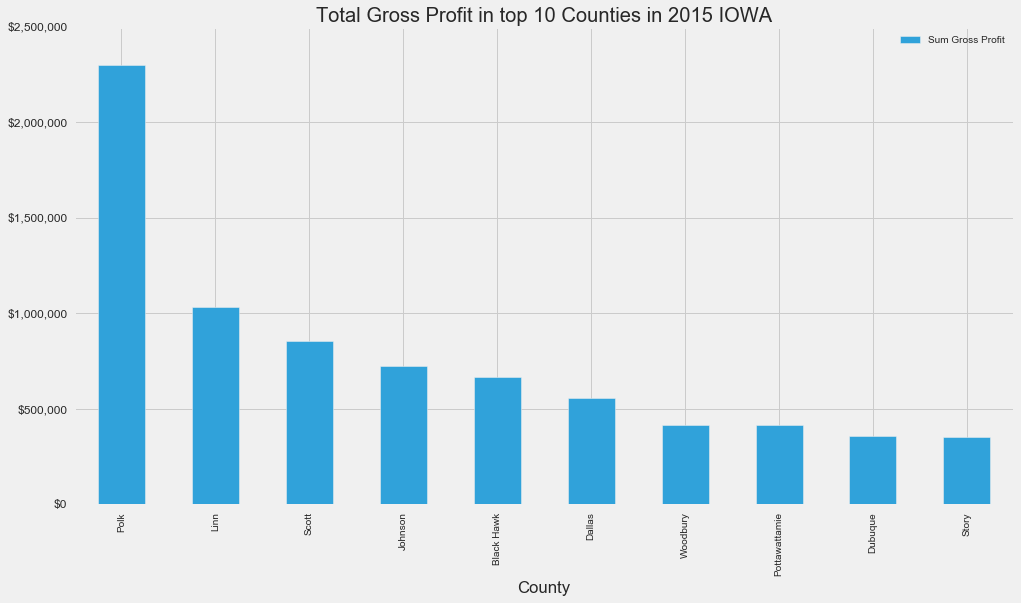

In [488]:
# Plotting total gross profit of each county for top 15 counties in descending sale

ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Sum Gross Profit', figsize = (15,8))

ax.set_title('Total Gross Profit in top 10 Counties in 2015 IOWA')
ax.set_xlabel('County')
ax.set_yticklabels(['$0', \
                    '$500,000', \
                    '$1,000,000', \
                    '$1,500,000', \
                    '$2,000,000', \
                    '$2,500,000', \
                    '$3,000,000' \
                   ], \
                   fontsize = 12 \
                  )
plt.savefig('top10_counties_gross_profit_bar.png');

### Plotting number of stores for top 10 sales (profit) counties

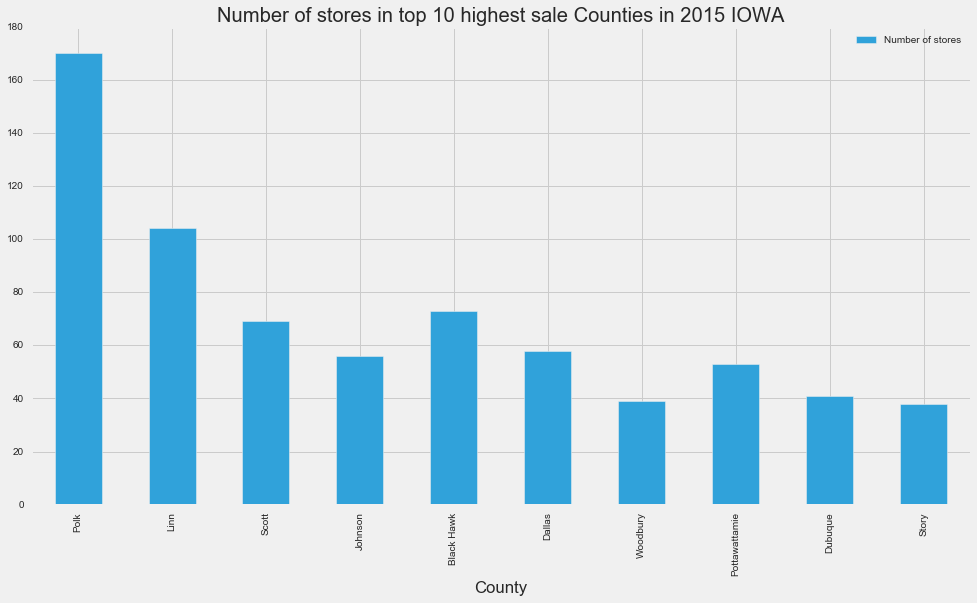

In [489]:
ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Number of stores', figsize = (15,8))

ax.set_title('Number of stores in top 10 highest sale Counties in 2015 IOWA')

plt.savefig('top10_counties_store_number_bar.png')

### Pivoting data based on county

In [490]:
df_15.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Sale Year,Sale Month,Bottle Gross Profit,Gross Profit
525069,2015-12-31,3400,DES MOINES,50317,77.0,Polk,1051140.0,PEACH BRANDIES,115,56195,...,3.22,4.83,24,115.92,9.0,2.38,2015,12,1.61,38.64
525070,2015-12-31,4165,ANKENY,50023,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,...,7.60,11.40,6,68.40,10.5,2.77,2015,12,3.80,22.80
525071,2015-12-31,4617,DES MOINES,50317,77.0,Polk,1031080.0,VODKA 80 PROOF,380,37348,...,7.60,11.40,6,68.40,10.5,2.77,2015,12,3.80,22.80
525072,2015-12-31,5089,MISSOURI VALLEY,51555,43.0,Harrison,1011100.0,BLENDED WHISKIES,260,27554,...,7.00,10.50,2,21.00,1.5,0.40,2015,12,3.50,7.00
525073,2015-12-31,4695,ALTOONA,50009,77.0,Polk,1081600.0,WHISKEY LIQUEUR,421,64866,...,8.98,13.47,12,161.64,9.0,2.38,2015,12,4.49,53.88


In [491]:
# Pivoting based on store number

st = pd.pivot_table(df_15, index = ['Store Number', \
                                    'County' \
                                   ], \
                    values = ['Bottles Sold', \
                              'Sale (Dollars)', \
                              'Gross Profit', \
                              'Bottle Gross Profit', \
                              'State Bottle Retail' \
                              ], \
                    aggfunc = [np.sum, \
                               np.mean, \
                               len] \
                    ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

st.reset_index(inplace=True)

st.head()                 

Store Number   County                 sum                            \
                        Bottle Gross Profit Bottles Sold Gross Profit   
0         2633     Polk           119922.29       595205   3282140.27   
1         4829     Polk           115000.14       520100   2916236.61   
2         2512  Johnson            77509.56       282804   1387461.81   
3         3385     Linn            29537.97       245312   1318267.65   
4         3420     Polk            19700.44       192664   1143907.91   

                                                    mean               \
  Sale (Dollars) State Bottle Retail Bottle Gross Profit Bottles Sold   
0     9839393.08           359200.19            6.147339    30.510816   
1     8742779.31           344628.84            6.314526    28.558094   
2     4155665.47           232070.24            5.430502    19.813914   
3     3947176.01            88458.66            6.024469    50.033041   
4     3422351.55            59013.99            6.324379    61.850401   

                                                                  len  \
  Gross Profit Sale (Dollars) State Bottle Retail Bottle Gross Profit   
0   168.245862     504.377336           18.412969             19508.0   
1   160.127202     480.055969           18.923174             18212.0   
2    97.208843     291.155711           16.259388             14273.0   
3   268.869600     805.053235           18.041742              4903.0   
4   367.225653    1098.668234           18.945101              3115.0   

                                                                
  Bottles Sold Gross Profit Sale (Dollars) State Bottle Retail  
0        19508      19508.0        19508.0             19508.0  
1        18212      18212.0        18212.0             18212.0  
2        14273      14273.0        14273.0             14273.0  
3         4903       4903.0         4903.0              4903.0  
4         3115       3115.0         3115.0              3115.0

In [492]:
st['County'].nunique()

99

In [493]:
# Extracting relevant columns into a new df

st_n = pd.concat([st['Store Number'], \
                  st['County'], \
                  st[('sum', 'Sale (Dollars)')], \
                  st[('sum', 'Gross Profit')], \
                  st[('sum', 'Bottles Sold')], \
                  st[('mean', 'State Bottle Retail')], \
                  st[('mean', 'Bottle Gross Profit')], \
                  st[('len', 'Bottles Sold')]
                  ],\
                 axis = 1)

st_n.columns = ['Store Number',\
                'County', \
                'Sum Sale', \
                'Sum Profit', \
                'Sum Bottles Sold', \
                "Avg Bottle Price", \
                "Avg Bottle Profit", \
                "No. Trans" \
               ]

st_n['Avg Bottle Price'] = st_n['Avg Bottle Price'].apply(lambda x: round(x, 2))

st_n.sort_values(['Sum Sale'], ascending = False, inplace=True)

st_n.head(10)

,Store Number,County,Sum Sale,Sum Profit,Sum Bottles Sold,Avg Bottle Price,Avg Bottle Profit,No. Trans
0,2633,Polk,9839393.08,3282140.27,595205,18.41,6.147339,19508
1,4829,Polk,8742779.31,2916236.61,520100,18.92,6.314526,18212
2,2512,Johnson,4155665.47,1387461.81,282804,16.26,5.430502,14273
3,3385,Linn,3947176.01,1318267.65,245312,18.04,6.024469,4903
4,3420,Polk,3422351.55,1143907.91,192664,18.95,6.324379,3115
5,3952,Scott,3045758.76,1016033.39,177414,20.12,6.713353,9185
6,3814,Dallas,2899984.38,968708.59,117462,26.07,8.697215,1235
7,2670,Johnson,2402265.82,802301.54,156560,16.34,5.458111,12331
8,3354,Scott,2385085.09,796769.69,139726,18.21,6.080612,3380
9,3773,Linn,2297121.49,766240.33,131936,20.31,6.775259,9355


In [494]:
st_n.describe()

,Store Number,Sum Sale,Sum Profit,Sum Bottles Sold,Avg Bottle Price,Avg Bottle Profit,No. Trans
count,1375.000000,1.375000e+03,1.375000e+03,1375.000000,1375.000000,1375.000000,1375.000000
mean,4249.112727,2.067844e+05,6.913828e+04,15689.049455,13.660284,4.565034,1588.714909
std,857.290128,5.031273e+05,1.679676e+05,31518.959294,2.802586,0.935457,2239.505554
min,2106.000000,6.799800e+02,2.268000e+02,103.000000,4.540000,1.516000,1.000000
25%,3858.500000,3.086351e+04,1.031793e+04,3066.000000,11.690000,3.910221,308.000000
50%,4440.000000,7.142833e+04,2.389326e+04,6579.000000,13.550000,4.524549,810.000000
75%,4826.000000,1.917832e+05,6.416118e+04,15895.000000,15.245000,5.098804,1711.000000
max,9023.000000,9.839393e+06,3.282140e+06,595205.000000,36.950000,12.335581,19508.000000


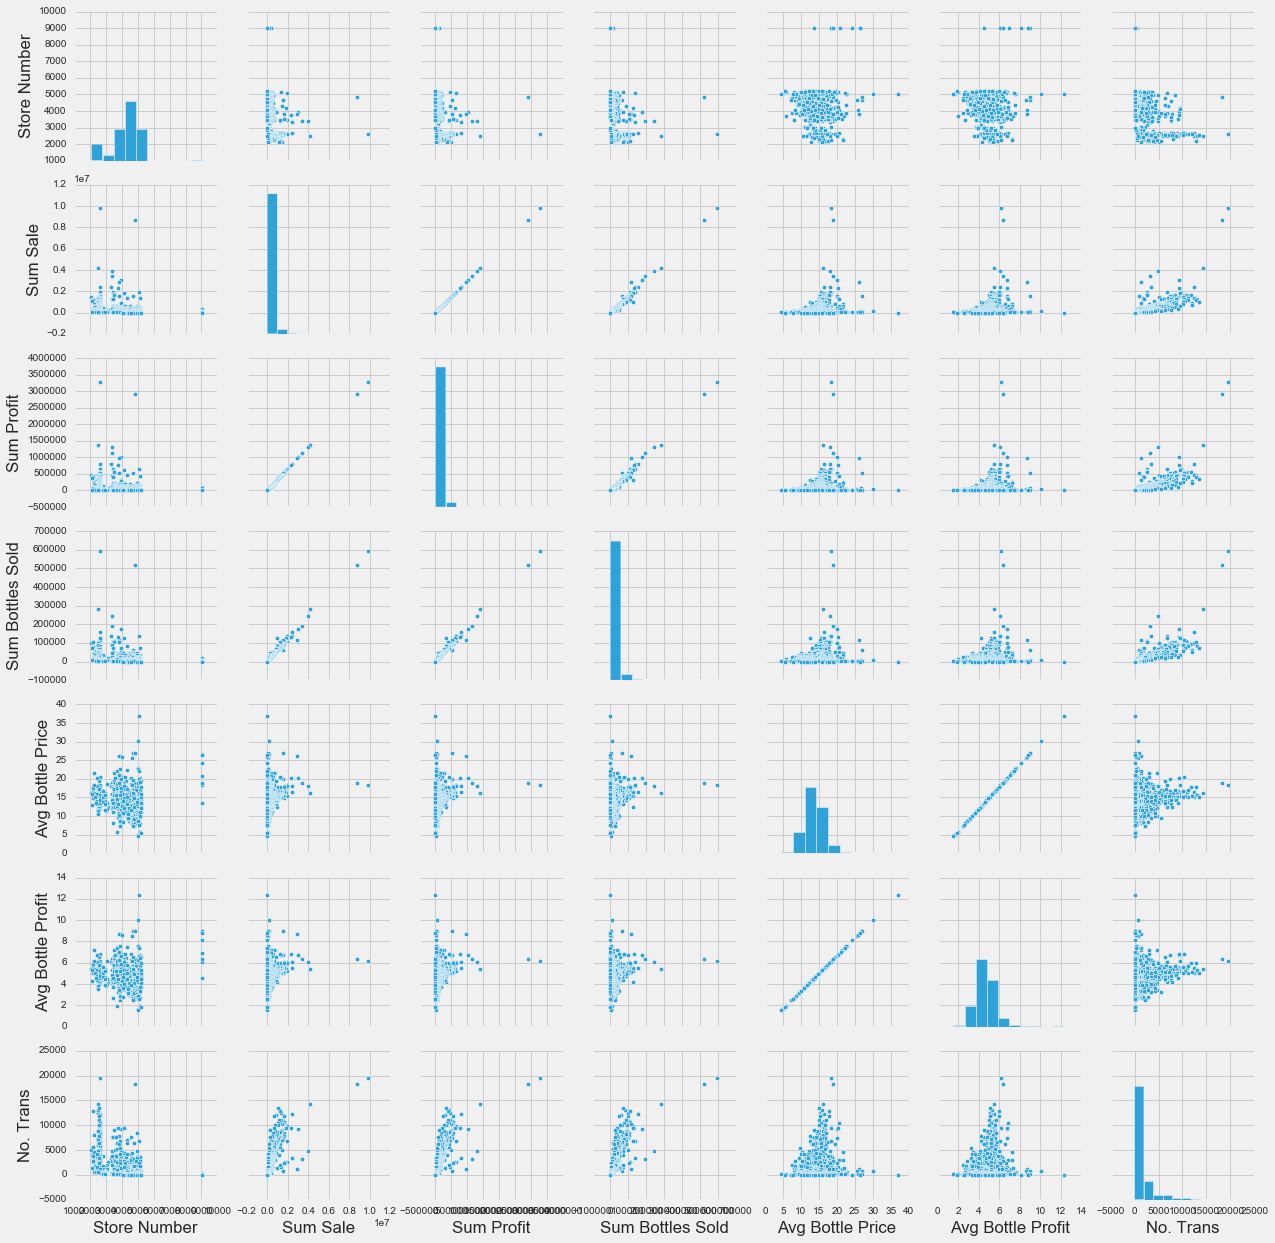

In [495]:
import seaborn as sns
sns.pairplot(st_n)
plt.savefig('pairplot.png');

### Demonstrating skewness in sales data

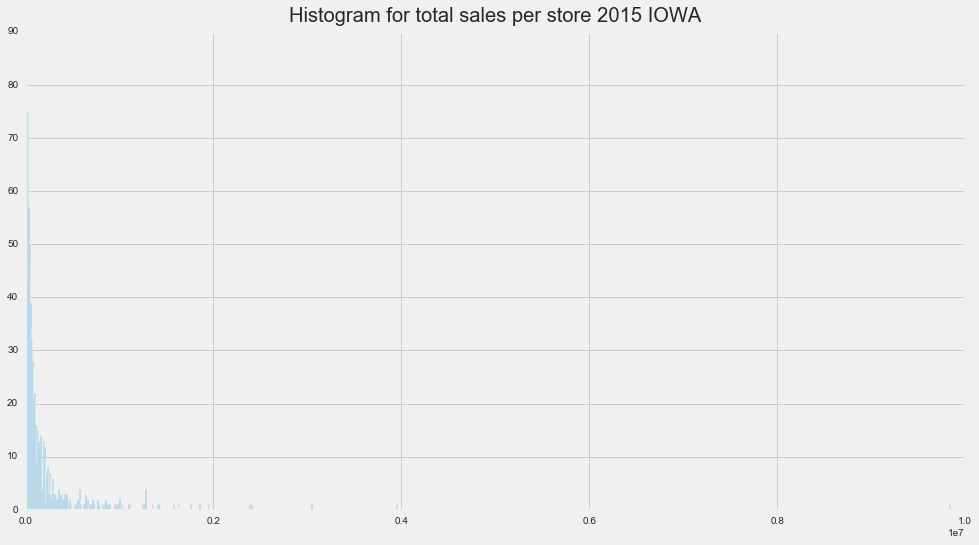

In [496]:
# Plotting histogram for sale per store in 2015

ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_title('Histogram for total sales per store 2015 IOWA', y = 1.01)
plt.savefig('total_sales_hist_skewed.png');

#### Comments:

Extreme outliers exists in sale per store data. There is a small representation near \$10,000,000 (1.0 e7) yearly sale. 75% of stores made less than \$200,000 (0.02 e7) in 2015.

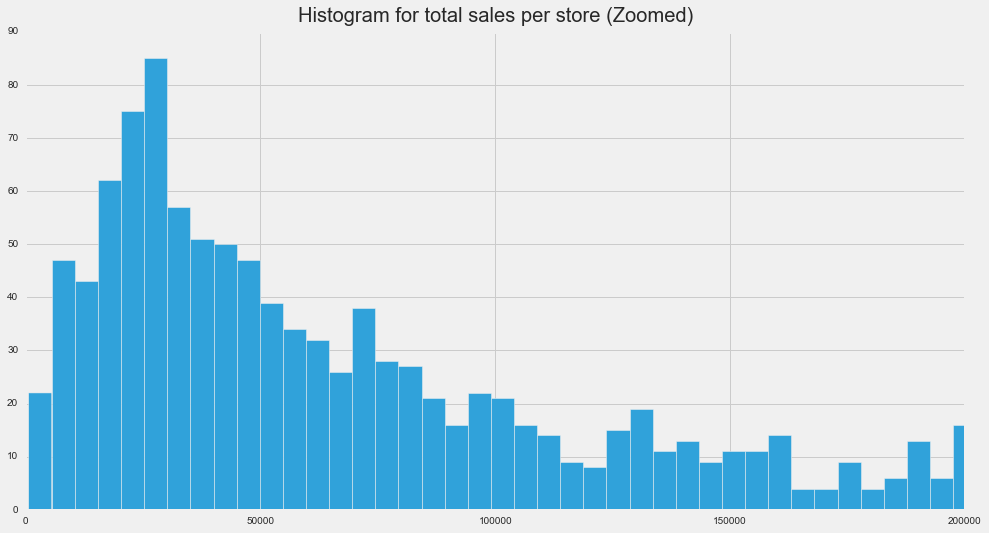

In [497]:
# Display sale performance of lower 75% of stores

ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,200000])
ax.set_title('Histogram for total sales per store (Zoomed)', y = 1.01)
plt.savefig('total_sales_hist_zoomed.png');

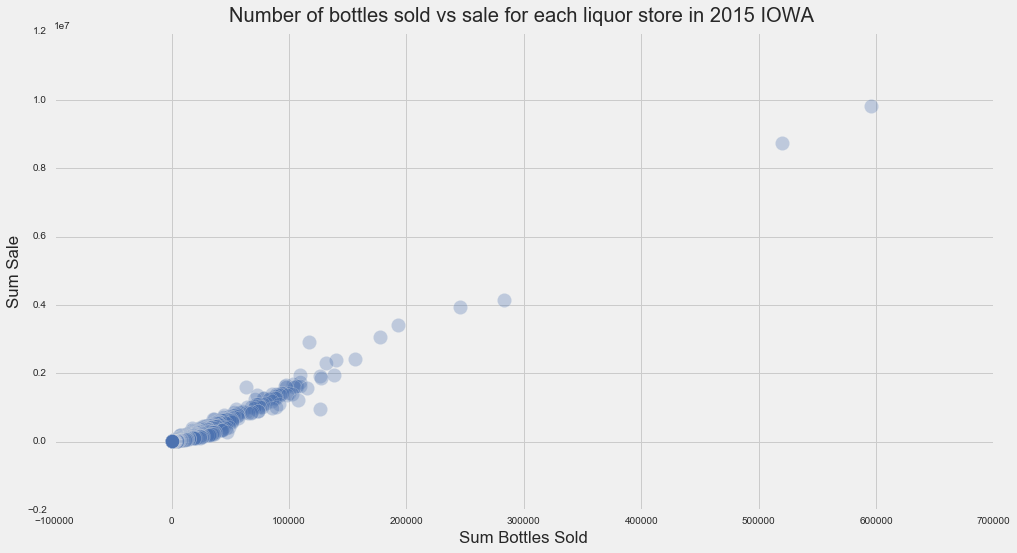

In [498]:
# Plotting number of bottles sold vs sale for each store in IOWA in 2015

ax = st_n.plot(kind = 'scatter', x = 'Sum Bottles Sold', y = 'Sum Sale',\
                  s = 200, alpha = 0.3, figsize = (15,8))
ax.set_title('Number of bottles sold vs sale for each liquor store in 2015 IOWA ', y = 1.01)
plt.savefig('bottles_vs_sale.png');

In [499]:
st_n.tail()

,Store Number,County,Sum Sale,Sum Profit,Sum Bottles Sold,Avg Bottle Price,Avg Bottle Profit,No. Trans
1370,4486,Dickinson,1232.38,410.99,103,12.18,4.062000,15
1371,4939,Polk,1120.70,373.71,110,13.92,4.640465,43
1372,5056,Pottawattamie,973.58,324.77,158,7.70,2.568500,60
1373,4567,Polk,827.13,276.40,118,11.68,3.915000,18
1374,5213,Lee,679.98,226.80,168,5.56,1.853333,9


In [500]:
# View of outliers

st_n[st_n['Sum Bottles Sold'] >= 100000]

,Store Number,County,Sum Sale,Sum Profit,Sum Bottles Sold,Avg Bottle Price,Avg Bottle Profit,No. Trans
0,2633,Polk,9839393.08,3282140.27,595205,18.41,6.147339,19508
1,4829,Polk,8742779.31,2916236.61,520100,18.92,6.314526,18212
2,2512,Johnson,4155665.47,1387461.81,282804,16.26,5.430502,14273
3,3385,Linn,3947176.01,1318267.65,245312,18.04,6.024469,4903
4,3420,Polk,3422351.55,1143907.91,192664,18.95,6.324379,3115
5,3952,Scott,3045758.76,1016033.39,177414,20.12,6.713353,9185
6,3814,Dallas,2899984.38,968708.59,117462,26.07,8.697215,1235
7,2670,Johnson,2402265.82,802301.54,156560,16.34,5.458111,12331
8,3354,Scott,2385085.09,796769.69,139726,18.21,6.080612,3380
9,3773,Linn,2297121.49,766240.33,131936,20.31,6.775259,9355


In [501]:
print "Mean total sale per store across state is", "$" + str(round(st_n['Sum Sale'].mean(), 2))
print "Median total sale per store across state is", "$" + str(round(st_n['Sum Sale'].median(), 2))
print "Standard deviation of total sale per store across state is", "$" + str(round(st_n['Sum Sale'].std(), 2))
print

print "Mean total bottles sold per store across state is", round(st_n['Sum Bottles Sold'].mean(), 2), "bottles."
print "Median total bottles sold per store across state is", round(st_n['Sum Bottles Sold'].median(), 2), "bottles."
print "Standard deviation of total bottles sold per store across state is", round(st_n['Sum Bottles Sold'].std(), 2), "bottles."

Mean total sale per store across state is $206784.42
Median total sale per store across state is $71428.33
Standard deviation of total sale per store across state is $503127.27

Mean total bottles sold per store across state is 15689.05 bottles.
Median total bottles sold per store across state is 6579.0 bottles.
Standard deviation of total bottles sold per store across state is 31518.96 bottles.


## Best = Maximum total sale or Highest average sale?

### Maximum total sales

Using maximum total sale as the indicative performance metric for a "good" location, we see that Polk County, is the overwhelming favourite location. As we saw from the earlier data exploration, the reasons for Polk's stellar performance was mainly due to:

   1) The presence of 2 extreme outlying stores, with annual sale of between \$9 to \$10mil, 50 times more than 75% of all stores.

   2) 208 stores in Polk, twice as many as the next highest county, Linn with 104. 75% of of the counties have 13 or less stores.

We envision that a client with strong financials, proven management record and liquor-store expertise, with the desire to gain market share, would be interested in establishing a presence in Polk.

### Highest average sales

Another metric to describe liquor sale performance for a county is to consider the average store sale within the county and to pick the county with the "Highest average" sale.

In the case of a smaller scale expansion, "Highest average" is recommended, giving a more balanced consideration to competition and market size.

## Using median as average due to presence of strong outliers

In [502]:
# Pivoting based on county

st_piv = pd.pivot_table(st_n, \
                        index = ['County'], \
                        aggfunc = [ \
                                   sum, \
                                   np.median, \
                                   pd.Series.nunique \
                                  ] \
                        ).sort_values(\
                                      [('median', \
                                        'Sum Sale') \
                                      ], \
                                      ascending = False \
                                      )
st_piv.reset_index(inplace=True)

st_piv.head(2)

County              sum                                           \
              Avg Bottle Price Avg Bottle Profit No. Trans Store Number   
0  Winneshiek            74.36         24.847680     10610        21303   
1       Jones            57.85         19.340138     15688        14120   

                                                    median                    \
  Sum Bottles Sold Sum Profit    Sum Sale Avg Bottle Price Avg Bottle Profit   
0            92729  430029.68  1284923.04            15.55          5.194626   
1            78395  340273.05  1015238.25            14.16          4.734456   

    ...                                                    nunique  \
    ...    Sum Bottles Sold Sum Profit   Sum Sale Avg Bottle Price   
0   ...             21382.0  94620.930  282036.82              5.0   
1   ...             19753.5  89055.325  265864.93              4.0   

                                                                        \
  Avg Bottle Profit No. Trans Store Number Sum Bottles Sold Sum Profit   
0               5.0         5            5                5        5.0   
1               4.0         4            4                4        4.0   

            
  Sum Sale  
0      5.0  
1      4.0  

[2 rows x 22 columns]

In [503]:
st_piv.tail()

County              sum                                           \
               Avg Bottle Price Avg Bottle Profit No. Trans Store Number   
94   Van Buren            41.52         13.875271      1920        13004   
95       Boone           153.19         51.235580     13827        50882   
96     Calhoun           100.01         33.478792      3626        38457   
97     Fremont            11.32          3.784972       179         4573   
98  Pocahontas            66.21         22.140096      4176        22988   

                                                     median                    \
   Sum Bottles Sold Sum Profit    Sum Sale Avg Bottle Price Avg Bottle Profit   
94            12806   58233.45   174245.69           14.820          4.954927   
95           111414  489592.81  1460658.62           13.280          4.444383   
96            27280  107962.44   322593.15           12.335          4.124330   
97             2512    8029.92    24029.55           11.320          3.784972   
98            26493  109851.94   327370.38           13.200          4.415556   

     ...                                                    nunique  \
     ...    Sum Bottles Sold Sum Profit   Sum Sale Avg Bottle Price   
94   ...              2775.0   9707.970  29039.550              3.0   
95   ...              3128.0   9219.105  27579.465             12.0   
96   ...              2287.5   9194.815  27421.085              8.0   
97   ...              2512.0   8029.920  24029.550              1.0   
98   ...              2194.0   7290.530  21806.940              5.0   

                                                                         \
   Avg Bottle Profit No. Trans Store Number Sum Bottles Sold Sum Profit   
94               3.0         3            3                3        3.0   
95              12.0        12           12               12       12.0   
96               8.0         8            8                8        8.0   
97               1.0         1            1                1        1.0   
98               5.0         5            5                5        5.0   

             
   Sum Sale  
94      3.0  
95     12.0  
96      8.0  
97      1.0  
98      5.0  

[5 rows x 22 columns]

In [504]:
# Selecting required columns to view county performance based on median

median_county = pd.concat([st_piv['County'], \
                           st_piv[('sum', 'Sum Sale')], \
                           st_piv[('sum', 'Sum Profit')], \
                           st_piv[('sum', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Sum Sale')], \
                           st_piv[('median', 'Sum Profit')], \
                           st_piv[('median', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Avg Bottle Price')], \
                           st_piv[('median', 'Avg Bottle Profit')], \
                           st_piv[('median', 'No. Trans')], \
                           st_piv[('nunique', 'Store Number')], \
                           st_piv[('sum', 'No. Trans')]], \
                          axis = 1)

# Renaming the columns

median_county.columns = ['County', \
                         'Sum Sale', \
                         'Sum Profit', \
                         'Sum Bottles Sold', \
                         'Median Sale', \
                         'Median Profit', \
                         "Median Bottles Sold", \
                         "Median Bottle Price", \
                         "Median Bottle Profit", \
                         "Median No. Trans", \
                         'No. of stores',\
                         'No. of trans']

median_county.sort_values(['Median Sale'], ascending = False, inplace=True)

median_county.head(10)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans
0,Winneshiek,1284923.04,430029.68,92729,282036.820,94620.930,21382.0,15.550,5.194626,2352.0,5,10610
1,Jones,1015238.25,340273.05,78395,265864.930,89055.325,19753.5,14.160,4.734456,2721.5,4,15688
2,Kossuth,1769012.89,593456.47,124337,232513.300,77923.080,13883.0,15.480,5.172478,1301.0,7,13899
3,Monona,519700.46,173605.51,42020,222135.340,74241.400,15276.0,13.930,4.652009,3372.0,3,10023
4,Lucas,415069.06,138959.50,31177,207534.530,69479.750,15588.5,14.440,4.825699,2038.0,2,4076
5,Cerro Gordo,5751979.57,1925108.76,448722,180305.020,60227.480,14207.0,13.810,4.620619,1549.0,20,52216
6,Mahaska,1238308.70,414259.06,101125,177137.550,59251.500,14626.0,13.700,4.583415,1294.0,7,12579
7,Union,968807.50,324288.44,70322,149868.450,50236.720,11006.5,13.990,4.677189,1175.0,6,9061
8,Howard,710520.03,238239.97,49092,145839.060,48919.670,10339.0,14.700,4.917324,1133.0,3,5292
9,Ida,547270.83,183333.65,38825,140079.055,47053.910,10826.0,15.685,5.237217,1059.5,4,4811


In [505]:
median_county.tail()

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans
94,Van Buren,174245.69,58233.45,12806,29039.550,9707.970,2775.0,14.820,4.954927,298.0,3,1920
95,Boone,1460658.62,489592.81,111414,27579.465,9219.105,3128.0,13.280,4.444383,351.5,12,13827
96,Calhoun,322593.15,107962.44,27280,27421.085,9194.815,2287.5,12.335,4.124330,236.0,8,3626
97,Fremont,24029.55,8029.92,2512,24029.550,8029.920,2512.0,11.320,3.784972,179.0,1,179
98,Pocahontas,327370.38,109851.94,26493,21806.940,7290.530,2194.0,13.200,4.415556,219.0,5,4176


In [506]:
median_county.sort_values('Median Profit', ascending = False).head(10)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans
0,Winneshiek,1284923.04,430029.68,92729,282036.820,94620.930,21382.0,15.550,5.194626,2352.0,5,10610
1,Jones,1015238.25,340273.05,78395,265864.930,89055.325,19753.5,14.160,4.734456,2721.5,4,15688
2,Kossuth,1769012.89,593456.47,124337,232513.300,77923.080,13883.0,15.480,5.172478,1301.0,7,13899
3,Monona,519700.46,173605.51,42020,222135.340,74241.400,15276.0,13.930,4.652009,3372.0,3,10023
4,Lucas,415069.06,138959.50,31177,207534.530,69479.750,15588.5,14.440,4.825699,2038.0,2,4076
5,Cerro Gordo,5751979.57,1925108.76,448722,180305.020,60227.480,14207.0,13.810,4.620619,1549.0,20,52216
6,Mahaska,1238308.70,414259.06,101125,177137.550,59251.500,14626.0,13.700,4.583415,1294.0,7,12579
7,Union,968807.50,324288.44,70322,149868.450,50236.720,11006.5,13.990,4.677189,1175.0,6,9061
8,Howard,710520.03,238239.97,49092,145839.060,48919.670,10339.0,14.700,4.917324,1133.0,3,5292
9,Ida,547270.83,183333.65,38825,140079.055,47053.910,10826.0,15.685,5.237217,1059.5,4,4811


### Comments:

Top 10 counties in sales were also top 10 in gross profit (same positions)

In [507]:
# Adding a column of mean bottles per transaction

median_county["Mean bottles per trans"] = median_county['Sum Bottles Sold'] / median_county['No. of trans']

## Adding additional data: County Population (2010) and County Area

[Source](https://en.wikipedia.org/wiki/List_of_counties_in_Iowa)

In [508]:
#Importing demographics data

df_demo = pd.read_csv('iowa_demographics.csv')
df_demo.head()

,County,Population,Area
0,Adair County,7682,569�sq�mi
1,Adams County,4029,424�sq�mi
2,Allamakee County,14330,640�sq�mi
3,Appanoose County,12884,496�sq�mi
4,Audubon County,6119,443�sq�mi


In [509]:
# Cleaning County column
df_demo['County'] = df_demo['County'].apply(lambda x: x.split()[0])
df_demo.head()

,County,Population,Area
0,Adair,7682,569�sq�mi
1,Adams,4029,424�sq�mi
2,Allamakee,14330,640�sq�mi
3,Appanoose,12884,496�sq�mi
4,Audubon,6119,443�sq�mi


In [510]:
# Cleaning Population column

df_demo['Population'] = df_demo['Population'].astype(int)

In [511]:
# Extracting only the numeric value of land area

df_demo['Area'] = df_demo['Area'].apply(lambda x: float(x.split('\xff')[0]))

### Concatenating County sales data to county demographic data

In [512]:
# Sorting county dataframe into ascending alphabetical order

median_county.sort_values('County', inplace = True)
median_county.head(2)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans
79,Adair,424750.82,142154.58,35049,45065.175,15073.98,3608.0,13.315,4.454842,337.5,8,4436,7.901037
25,Adams,201132.71,67216.56,15902,100566.355,33608.28,7951.0,14.900,4.975778,1697.5,2,3395,4.683947


In [513]:
# Concatenating the 2 dataframes then sorting by median sale descending

median_county = pd.concat([median_county, df_demo.iloc[:, 1:]], axis = 1)
median_county.sort_values('Median Sale', ascending = False, inplace = True)
median_county.head(2)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area
0,Winneshiek,1284923.04,430029.68,92729,282036.82,94620.930,21382.0,15.55,5.194626,2352.0,5,10610,8.739774,7682,569.0
1,Jones,1015238.25,340273.05,78395,265864.93,89055.325,19753.5,14.16,4.734456,2721.5,4,15688,4.997132,4029,424.0


In [514]:
# Adding additional columns of new features to data:
# Area per store
# Population per store

median_county['Area per store'] = median_county['Area'] / median_county['No. of stores']
median_county['Population per store'] = median_county['Population'] / median_county['No. of stores']
median_county.head()

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
0,Winneshiek,1284923.04,430029.68,92729,282036.82,94620.930,21382.0,15.55,5.194626,2352.0,5,10610,8.739774,7682,569.0,113.800000,1536.400000
1,Jones,1015238.25,340273.05,78395,265864.93,89055.325,19753.5,14.16,4.734456,2721.5,4,15688,4.997132,4029,424.0,106.000000,1007.250000
2,Kossuth,1769012.89,593456.47,124337,232513.30,77923.080,13883.0,15.48,5.172478,1301.0,7,13899,8.945751,14330,640.0,91.428571,2047.142857
3,Monona,519700.46,173605.51,42020,222135.34,74241.400,15276.0,13.93,4.652009,3372.0,3,10023,4.192358,12884,496.0,165.333333,4294.666667
4,Lucas,415069.06,138959.50,31177,207534.53,69479.750,15588.5,14.44,4.825699,2038.0,2,4076,7.648921,6119,443.0,221.500000,3059.500000


In [515]:
median_county.describe()

,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
count,9.900000e+01,9.900000e+01,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,2.872006e+06,9.602538e+05,2.179035e+05,83695.952121,28025.092879,6932.984848,13.630707,4.556956,890.005051,13.888889,22065.484848,7.983274,30771.232323,564.252525,95.206532,4668.440093
std,6.906961e+06,2.307696e+06,5.214652e+05,50275.205270,16846.743649,3669.154178,0.996045,0.331798,509.796475,22.579966,43661.507488,1.993099,52888.737875,118.279791,73.568922,7160.258960
min,2.402955e+04,8.029920e+03,2.512000e+03,21806.940000,7290.530000,2194.000000,11.320000,3.784972,179.000000,1.000000,179.000000,4.062500,4029.000000,381.000000,3.488095,97.351190
25%,4.371315e+05,1.463007e+05,3.643300e+04,48937.050000,16366.487500,4089.500000,12.960000,4.327042,537.000000,5.000000,4623.500000,6.804520,10430.500000,479.000000,49.875000,1166.194444
50%,8.353819e+05,2.794350e+05,6.284500e+04,73801.510000,24788.660000,6031.000000,13.580000,4.541943,766.000000,7.000000,8662.000000,7.759347,15679.000000,569.000000,81.714286,2132.571429
75%,1.781668e+06,5.974303e+05,1.279840e+05,100780.882500,33675.510000,8436.000000,14.410000,4.818296,1097.000000,11.500000,16620.000000,9.408958,24631.000000,586.000000,117.725000,4396.666667
max,5.571048e+07,1.861268e+07,4.134606e+06,282036.820000,94620.930000,21382.000000,15.685000,5.237217,3372.000000,168.000000,331769.000000,14.033520,430640.000000,973.000000,416.000000,40325.000000


In [516]:
median_county.to_csv('iowa_county.csv')

In [517]:
# Extracting median population per store

print "Median population per store is", np.median(median_county['Population per store'])
print "Median area per store is", np.median(median_county['Area per store'])

Median population per store is 2132.57142857
Median area per store is 81.7142857143


### Re-visiting counties with highest sales now that we have demographics supplements

In [518]:
# Showing highest sum sale for comparison with demographics data

median_county.sort_values('Sum Sale', ascending = False).head(10)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
47,Polk,55710484.38,18612680.69,4134606,74632.925,24937.280,8026.5,13.695,4.569838,871.5,168,331769,12.462304,16355,586.0,3.488095,97.351190
52,Linn,24989946.22,8352223.74,1960733,71209.610,23840.850,6579.0,12.980,4.330782,744.0,101,187851,10.437703,20638,575.0,5.693069,204.336634
12,Scott,20800511.84,6946980.46,1693353,129922.000,43342.760,12832.0,13.220,4.420399,1123.0,67,137384,12.325693,9670,570.0,8.507463,144.328358
36,Johnson,17737144.45,5926284.02,1251346,82594.430,27694.465,7135.5,14.715,4.914076,806.0,54,109467,11.431262,9336,568.0,10.518519,172.888889
21,Black Hawk,16064552.82,5370097.77,1404315,105595.310,35259.210,11732.5,12.850,4.293176,1098.0,72,121019,11.604087,18129,779.0,10.819444,251.791667
69,Dallas,13890581.61,4643884.76,900038,51646.230,17254.145,5209.0,13.360,4.462731,737.0,58,87870,10.242836,42745,439.0,7.568966,736.982759
29,Woodbury,10115238.44,3379428.29,764809,94796.150,31659.500,8012.0,13.950,4.664961,1050.0,38,69172,11.056627,16667,381.0,10.026316,438.605263
67,Pottawattamie,10056843.86,3358791.00,765553,52873.010,17653.535,6250.0,12.275,4.107096,541.5,52,73900,10.359310,7970,433.0,8.326923,153.269231
65,Dubuque,8710159.48,2913344.81,636433,58030.805,19418.740,5243.0,13.245,4.421179,467.0,40,62196,10.232700,10776,469.0,11.725000,269.400000
61,Story,8559325.44,2862861.31,621112,63618.100,21281.980,5758.0,13.555,4.528608,794.0,38,72738,8.539030,22381,571.0,15.026316,588.973684


#### Comments:

Median for population per store is about 2300, while mean stood at about 4700. Median and mean for area per store are 81 and 99 sq miles. Constrast this with the top 10 counties with highest total sales, where almost none came close to these values.

### Examining highest population and area per store - Largest potential market size?

In [519]:
median_county.sort_values('Population per store', ascending = False).head(10)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
28,Davis,96185.96,32172.66,7746,96185.960,32172.660,7746.0,13.730,4.589286,1555.0,1,1555,4.981350,40325,416.0,416.000000,40325.000000
76,Clayton,601749.70,201229.86,43328,46431.170,15512.580,3661.0,13.580,4.536339,724.0,11,8895,4.871051,430640,570.0,51.818182,39149.090909
81,Louisa,232427.95,77619.59,29074,43492.540,14517.110,5962.0,11.650,3.894099,269.0,5,3789,7.673265,165224,458.0,91.600000,33044.800000
56,Cass,1142073.39,382098.90,81423,68037.160,22724.770,5345.0,13.530,4.524549,565.0,9,10048,8.103404,211226,718.0,79.777778,23469.555556
6,Mahaska,1238308.70,414259.06,101125,177137.550,59251.500,14626.0,13.700,4.583415,1294.0,7,12579,8.039192,131090,567.0,81.000000,18727.142857
22,Worth,258916.55,86598.98,20766,104798.770,35007.930,7838.0,14.520,4.849425,1153.0,3,3009,6.901296,49116,695.0,231.666667,16372.000000
84,Iowa,631370.82,211914.59,48262,40636.110,13626.820,3463.0,12.940,4.323301,573.0,7,8063,5.985613,89542,573.0,81.857143,12791.714286
96,Calhoun,322593.15,107962.44,27280,27421.085,9194.815,2287.5,12.335,4.124330,236.0,8,3626,7.523442,102172,873.0,109.125000,12771.500000
89,Taylor,110598.35,36932.00,9360,37341.620,12468.490,3441.0,13.570,4.535086,766.0,3,2304,4.062500,35625,432.0,144.000000,11875.000000
77,Palo Alto,603797.30,202032.63,43833,46015.900,15388.210,3425.0,14.180,4.743013,532.5,8,8692,5.042913,93158,954.0,119.250000,11644.750000


In [520]:
median_county.sort_values('Area per store', ascending = False).head(10)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
28,Davis,96185.96,32172.66,7746,96185.960,32172.660,7746.0,13.73,4.589286,1555.0,1,1555,4.981350,40325,416.0,416.000000,40325.000000
97,Fremont,24029.55,8029.92,2512,24029.550,8029.920,2512.0,11.32,3.784972,179.0,1,179,14.033520,7598,400.0,400.000000,7598.000000
11,Osceola,259985.23,87008.46,19448,129992.615,43504.230,9724.0,14.44,4.826761,1493.5,2,2987,6.510880,14867,580.0,290.000000,7433.500000
83,Keokuk,149560.78,49997.94,13554,41553.810,13874.600,3819.0,12.79,4.269181,1014.0,3,2797,4.845906,33704,768.0,256.000000,11234.666667
25,Adams,201132.71,67216.56,15902,100566.355,33608.280,7951.0,14.90,4.975778,1697.5,2,3395,4.683947,8753,503.0,251.500000,4376.500000
22,Worth,258916.55,86598.98,20766,104798.770,35007.930,7838.0,14.52,4.849425,1153.0,3,3009,6.901296,49116,695.0,231.666667,16372.000000
4,Lucas,415069.06,138959.50,31177,207534.530,69479.750,15588.5,14.44,4.825699,2038.0,2,4076,7.648921,6119,443.0,221.500000,3059.500000
68,Wayne,105438.35,35262.99,8283,52719.175,17631.495,4141.5,13.31,4.448691,634.0,2,1268,6.532334,10740,424.0,212.000000,5370.000000
80,Ringgold,138680.81,46420.18,10061,45040.610,15085.350,3350.0,14.21,4.756918,425.0,3,1476,6.816396,10350,576.0,192.000000,3450.000000
70,Audubon,173849.23,58314.18,15202,50407.740,16869.740,4325.0,13.14,4.400205,636.0,3,2060,7.379612,14398,573.0,191.000000,4799.333333


#### Comments:

Counties with the highest population per store have rather low median sale. This means that while there seemingly large potential in terms of customer base, these counties may not have the highest target audience composition within their population, so may not be ideal candidates.

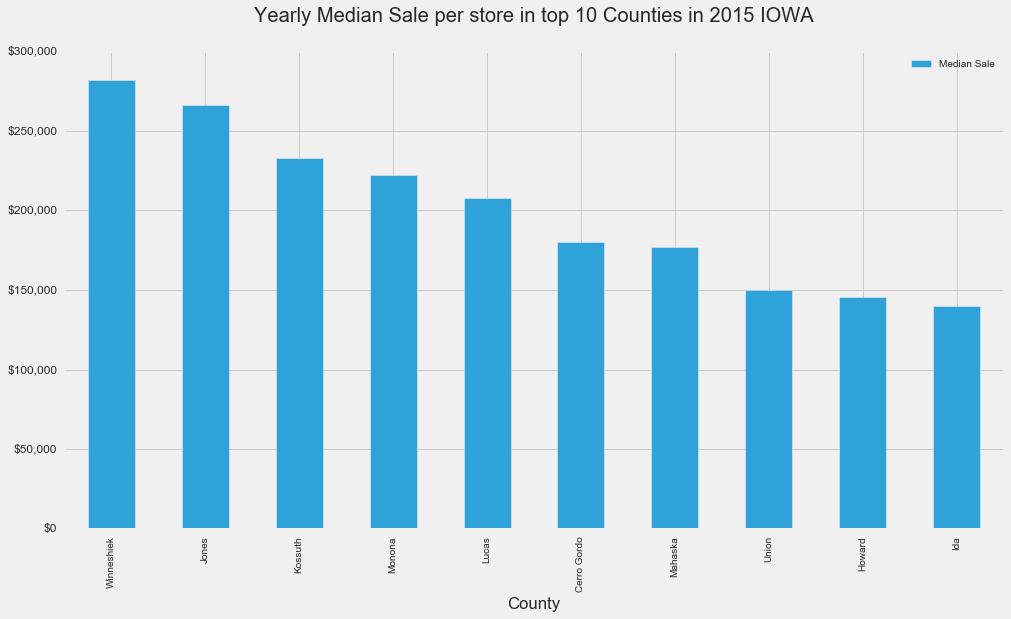

In [521]:
ax = median_county.head(10).plot(x = 'County', kind = "bar", \
                                 y = 'Median Sale', figsize = (15,8))

ax.set_title('Yearly Median Sale per store in top 10 Counties in 2015 IOWA', y = 1.05)
ax.set_xlabel('County')
ax.set_yticklabels(['$0', \
                    '$50,000', \
                    '$100,000', \
                    '$150,000', \
                    '$200,000', \
                    '$250,000', \
                    '$300,000' \
                   ], \
                   fontsize = 12 \
                  )
plt.savefig('top10_median_sales.png');

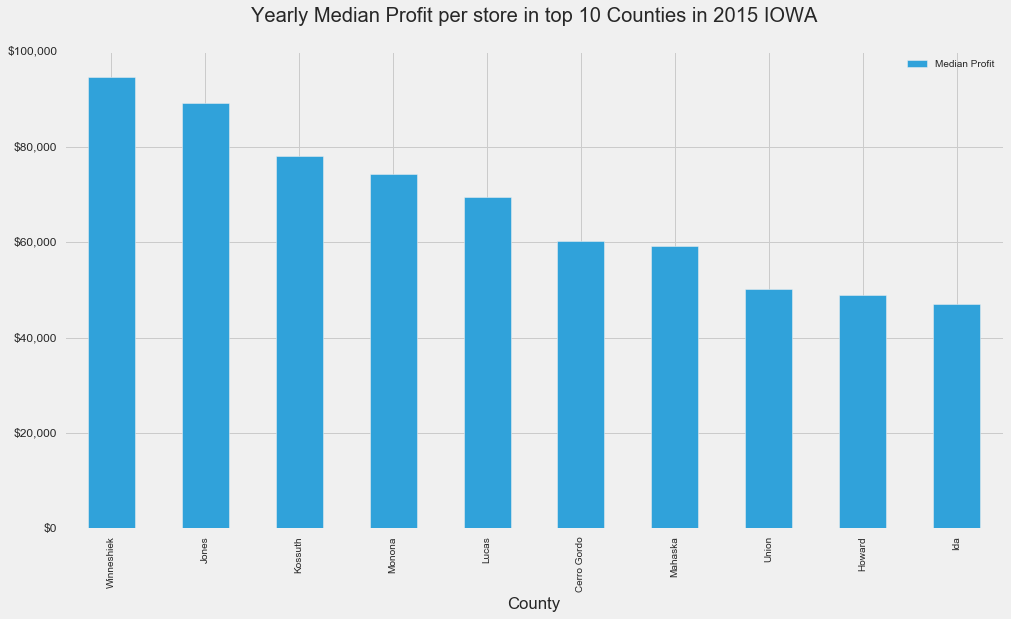

In [522]:
ax = median_county.head(10).plot(x = 'County', kind = "bar", \
                                 y = 'Median Profit', figsize = (15,8))

ax.set_title('Yearly Median Profit per store in top 10 Counties in 2015 IOWA', y = 1.05)
ax.set_xlabel('County')
ax.set_yticklabels(['$0', \
                    '$20,000', \
                    '$40,000', \
                    '$60,000', \
                    '$80,000', \
                    '$100,000' \
                   ], \
                   fontsize = 12 \
                  )
plt.savefig('Top10_median_profit.png');

In [523]:
# Display new performance positions of previous top 3 counties

median_county[(median_county['County'] == 'Polk')|\
              (median_county['County'] == 'Linn')|\
              (median_county['County'] == 'Scott')]

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
12,Scott,20800511.84,6946980.46,1693353,129922.000,43342.76,12832.0,13.220,4.420399,1123.0,67,137384,12.325693,9670,570.0,8.507463,144.328358
47,Polk,55710484.38,18612680.69,4134606,74632.925,24937.28,8026.5,13.695,4.569838,871.5,168,331769,12.462304,16355,586.0,3.488095,97.351190
52,Linn,24989946.22,8352223.74,1960733,71209.610,23840.85,6579.0,12.980,4.330782,744.0,101,187851,10.437703,20638,575.0,5.693069,204.336634


#### Comments:

Due to the presence of outliers, using mean would distort the data significantly. We see that using median as a metric shows a completely different list of top performing counties.

Interesting to note that from overwhelmingly high positions, Polk, Linn and Scott, are not even in the top 20 counties in median yearly sale (52nd, 55th and 18th position respectively).

## Modelling

### County : Winneshiek (Top Median sale) - using 2015 first 3 months to train model

In [524]:
# Filtering the df for data from first 3 months of 2015

dfm = df_15[((df_15['Sale Month'] == 1)|(df_15['Sale Month'] == 2)|(df_15['Sale Month'] == 3))\
        & (df_15['County'] == "Winneshiek")]

In [525]:
dfm_piv = pd.pivot_table(dfm, \
                         index = ['Store Number'], \
                         aggfunc = [\
                                    sum, \
                                    np.median, \
                                    len \
                                   ] \
                         ).sort_values([('sum', \
                                         'Sale (Dollars)')], \
                                       ascending = False \
                                       )
dfm_piv.reset_index(inplace=True)

dfm_piv.head()

Store Number                 sum                                  \
               Bottle Gross Profit Bottle Volume (ml) Bottles Sold   
0         3721             3310.48             782250         6774   
1         4183             2568.56             532875         4493   
2         3819             2913.23             611100         4344   
3         4818              910.87             192850         2450   
4         4762             1768.45             434875         1743   

                                                                      \
      Category County Number Gross Profit Item Number Sale (Dollars)   
0  672069881.0       61824.0     32561.10    28701014       97350.48   
1  541255468.0       49728.0     20984.06    24587159       62630.69   
2  606786878.0       55680.0     19121.24    26243445       57013.70   
3  213368865.0       19776.0      8794.12     7540075       26349.60   
4  379812724.0       34848.0      8525.34    16391426       25498.43   

               ...            len                                      \
  Sale Month   ...    Item Number Sale (Dollars) Sale Month Sale Year   
0       1302   ...            644          644.0        644       644   
1       1069   ...            518          518.0        518       518   
2       1160   ...            580          580.0        580       580   
3        413   ...            206          206.0        206       206   
4        712   ...            363          363.0        363       363   

                                                                             \
  State Bottle Cost State Bottle Retail Vendor Number Volume Sold (Gallons)   
0             644.0               644.0           644                 644.0   
1             518.0               518.0           518                 518.0   
2             580.0               580.0           580                 580.0   
3             206.0               206.0           206                 206.0   
4             363.0               363.0           363                 363.0   

                                 
  Volume Sold (Liters) Zip Code  
0                644.0      644  
1                518.0      518  
2                580.0      580  
3                206.0      206  
4                363.0      363  

[5 rows x 54 columns]

In [526]:
dfmm = pd.concat([dfm_piv[('median', 'State Bottle Cost')], \
                  dfm_piv[('median', 'State Bottle Retail')], \
                  dfm_piv[('median', 'Bottle Gross Profit')], \
                  dfm_piv[('sum', 'Bottles Sold')], \
                  dfm_piv[('sum', 'Volume Sold (Gallons)')], \
                  dfm_piv[('len', 'Item Number')] \
                  ], \
                 axis = 1 \
                )

# Renaming the columns

dfmm.columns = ["Median Bottle Cost", \
                "Median Bottle Price", \
                'Median Bottle Profit', \
                'Sum Bottles sold', \
                'Sum Volume sold', \
                'No. of trans' \
               ]

In [527]:
# Filtering the df for data from last 9 months of 2015

dft = df_15[((df_15['Sale Month'] != 1)|(df_15['Sale Month'] != 2)|(df_15['Sale Month'] != 3))\
        & (df_15['County'] == "Winneshiek")]

In [528]:
dft_piv = pd.pivot_table(dft, \
                         index = ['Store Number'], \
                         aggfunc = [sum, \
                                    np.median, \
                                    len] \
                         ).sort_values([('sum', \
                                         'Sale (Dollars)')], \
                                       ascending = False \
                                       )
dft_piv.reset_index(inplace=True)

In [529]:
dft_piv[('sum', 'Sale (Dollars)')].describe()

count         5.000000
mean     256984.608000
std      154357.007622
min      104634.380000
25%      111496.730000
50%      282036.820000
75%      312466.050000
max      474289.060000
Name: (sum, Sale (Dollars)), dtype: float64

In [530]:


dftt = pd.concat([dft_piv[('median', 'State Bottle Cost')], \
                  dft_piv[('median', 'State Bottle Retail')], \
                  dft_piv[('median', 'Bottle Gross Profit')], \
                  dft_piv[('sum', 'Bottles Sold')], \
                  dft_piv[('sum', 'Volume Sold (Gallons)')], \
                  dft_piv[('len', 'Item Number')] \
                  ], \
                 axis = 1 \
                )


# Renaming the columns

dftt.columns = ["Median Bottle Cost", \
                "Median Bottle Price", \
                'Median Bottle Profit', \
                'Sum Bottles sold', \
                'Sum Volume sold', \
                'No. of trans' \
               ]

### Using pure linear regression

In [531]:
X = dfmm
y = dfm_piv[('sum', 'Sale (Dollars)')]

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dftt)
print "r2 = ", r2_score(dft_piv[('sum', 'Sale (Dollars)')], pred)
print "MSE =", mean_squared_error(dft_piv[('sum', 'Sale (Dollars)')], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dft_piv[('sum', 'Sale (Dollars)')], pred)), 2)

print
print "Coefficients:" 

for i,j in zip(dftt.columns, lm.coef_):
    print i, ':', j

r2 =  0.668567643514
MSE = 6317388610.56
RMSE = 79482.0

Coefficients:
Median Bottle Cost : -5318.14368825
Median Bottle Price : -8010.34860718
Median Bottle Profit : -2828.49281531
Sum Bottles sold : -11.0849183433
Sum Volume sold : 83.8130635505
No. of trans : 58.1543146409


## Using RidgeCV

In [532]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dftt)

print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dft_piv[('sum', 'Sale (Dollars)')], pred_rcv)
print "MSE =", mean_squared_error(dft_piv[('sum', 'Sale (Dollars)')], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dft_piv[('sum', 'Sale (Dollars)')], pred_rcv)), 2)

print
print "Coefficients:" 

for i,j in zip(dftt.columns, rcv.coef_):
    print i, ':', j

Chosen alpha = 1e-08
r2 =  0.66856774738
MSE = 6317386630.79
RMSE = 79481.99

Coefficients:
Median Bottle Cost : -5318.14295748
Median Bottle Price : -8010.34750647
Median Bottle Profit : -2828.49242664
Sum Bottles sold : -11.0849167183
Sum Volume sold : 83.813059032
No. of trans : 58.1543044643


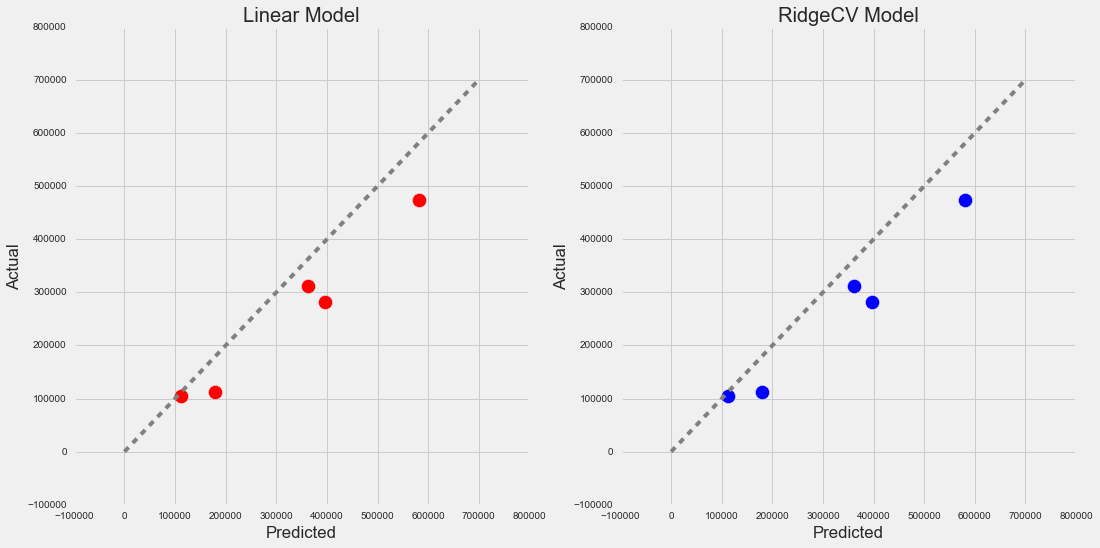

In [533]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dft_piv[('sum', 'Sale (Dollars)')], c='red', s = 200)
axes[0].plot([0, 700000], [0, 700000], ls="--", c='gray')

axes[1].scatter(pred_rcv, dft_piv[('sum', 'Sale (Dollars)')], c='b', s = 200)
axes[1].plot([0, 700000], [0, 700000], ls="--", c='gray')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.savefig('reg_15Q1_pred_15Q234.png');

#### Comments:

We see that using a RidgeCV regularization with 5 fold cross-validation, didn't change the performance of the model compared to a pure Linear Regression model. Chosen alpha is almost zero (1 e-8). Model's performance is rather poor, with r^2 of about 0.67 and a RMSE of about \$79,500. This error is considerable as it is based on a dataset with range of \$104,000 to \$474,000.

The main reason this is so is because the model was developed with a training set with 3 months of data and was used to predict performance for 9 month. That is why the scatterplots are all below the y=x line, since the model should alway under-predict the actual values.

### Using the 2015 Q1 models to predict 2016 Q1 performance

In [534]:
# Filtering the df for data from first 3 months of 2016

dfn = df_16[df_16['County'] == "Winneshiek"]

In [535]:
dfn_piv = pd.pivot_table(dfn, \
                         index = ['Store Number'], \
                         aggfunc = [sum, \
                                    np.median, \
                                    len] \
                         ).sort_values([('sum', \
                                         'Sale (Dollars)')], \
                                       ascending = False \
                                       )
dfn_piv.reset_index(inplace=True)


In [536]:
dfn_piv[('sum', 'Sale (Dollars)')].describe()

count         5.000000
mean      58775.738000
std       33146.578574
min       22731.510000
25%       29772.860000
50%       66412.200000
75%       70926.260000
max      104035.860000
Name: (sum, Sale (Dollars)), dtype: float64

In [537]:

dfnn = pd.concat([dfn_piv[('median', 'State Bottle Cost')], \
                  dfn_piv[('median', 'State Bottle Retail')], \
                  dfn_piv[('median', 'Bottle Gross Profit')], \
                  dfn_piv[('sum', 'Bottles Sold')], \
                  dfn_piv[('sum', 'Volume Sold (Gallons)')], \
                  dfn_piv[('len', 'Item Number')] \
                  ], \
                 axis = 1 \
                )


# Renaming the columns

dfnn.columns = ["Median Bottle Cost", \
                "Median Bottle Price", \
                'Median Bottle Profit', \
                'Sum Bottles sold', \
                'Sum Volume sold', \
                'No. of trans' \
               ]

In [538]:
pred16 = lm.predict(dfnn)
print "r2 = ", r2_score(dfn_piv[('sum', 'Sale (Dollars)')], pred16)
print "MSE =", mean_squared_error(dfn_piv[('sum', 'Sale (Dollars)')], pred16)
print "RMSE =", np.sqrt(mean_squared_error(dfn_piv[('sum', 'Sale (Dollars)')], pred16))

r2 =  0.891762493843
MSE = 95136063.5765
RMSE = 9753.77176156


In [539]:
pred_rcv16 = rcv.predict(dfnn)

print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfn_piv[('sum', 'Sale (Dollars)')], pred_rcv16)
print "MSE =", mean_squared_error(dfn_piv[('sum', 'Sale (Dollars)')], pred_rcv16)
print "RMSE =", round(np.sqrt(mean_squared_error(dfn_piv[('sum', 'Sale (Dollars)')], pred_rcv16)), 2)
print
print "Coefficients =" 

for i,j in zip(dfnn.columns, rcv.coef_):
    print i, ':', j

Chosen alpha = 1e-08
r2 =  0.891762524055
MSE = 95136037.0219
RMSE = 9753.77

Coefficients =
Median Bottle Cost : -5318.14295748
Median Bottle Price : -8010.34750647
Median Bottle Profit : -2828.49242664
Sum Bottles sold : -11.0849167183
Sum Volume sold : 83.813059032
No. of trans : 58.1543044643


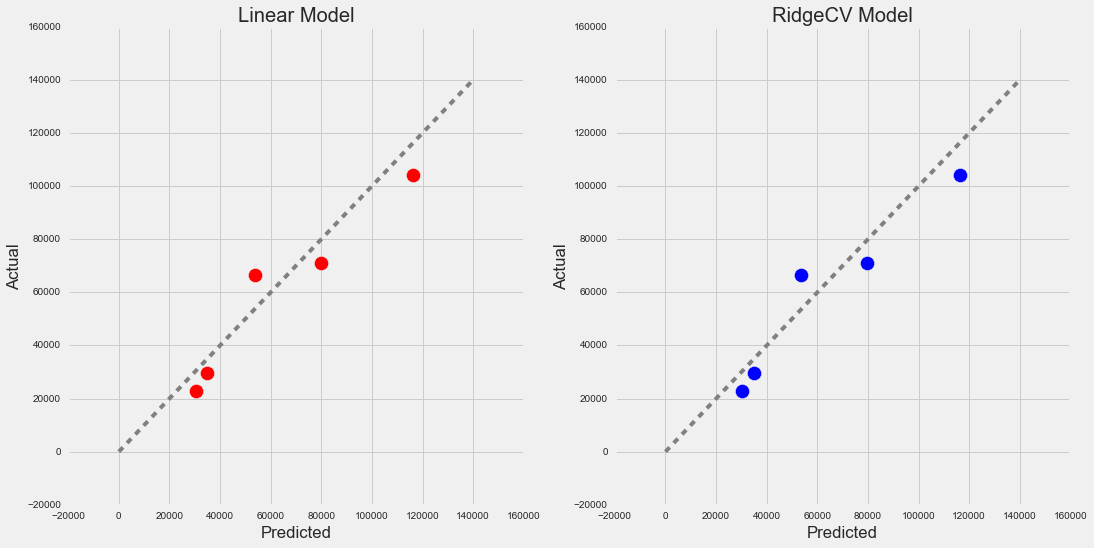

In [540]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred16, dfn_piv[('sum', 'Sale (Dollars)')], c='red', s = 200)
axes[0].plot([0, 140000], [0, 140000], ls="--", c='gray')

axes[1].scatter(pred_rcv16, dfn_piv[('sum', 'Sale (Dollars)')], c='b', s = 200)
axes[1].plot([0, 140000], [0, 140000], ls="--", c='gray')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.savefig('reg_15Q1_pred_16Q1.png');

#### Comments:

Performance of the same model on 2016 Q1 data is much better. RMSE reduced by a factor of about 7, about \$9,700 for predicted range of \$22,700 to \$104,000. RidgeCV is again chosing an alpha of almost zero, and we see high values for coefficients.

One possible reason for this could be the lack of data points in this county. With only 5 stores in the county, linear regression should not be used for modelling.

## Modelling for Polk (with outliers removed)

In [541]:
# Filtering the df for data from first 3 months of 2015

dfp = df_15[((df_15['Sale Month'] == 1)|(df_15['Sale Month'] == 2)|(df_15['Sale Month'] == 3))\
        & (df_15['County'] == "Polk")]

In [542]:
dfp_piv = pd.pivot_table(dfp, \
                         index = ['Store Number'], \
                         aggfunc = [\
                                    sum, \
                                    np.median, \
                                    len \
                                   ] \
                         ).sort_values([('sum', \
                                         'Sale (Dollars)')], \
                                       ascending = False \
                                       )
dfp_piv.reset_index(inplace=True)

In [543]:
# Setting positive and negative threshold for Polk data
# Removing data with sale volume over 3 SD above and below mean (keeping 99% of data)

threshold_p = dfp_piv[('sum', 'Bottles Sold')].mean() + (3 * dfp_piv[('sum', 'Bottles Sold')].std())
threshold_n = dfp_piv[('sum', 'Bottles Sold')].mean() - (3 * dfp_piv[('sum', 'Bottles Sold')].std())

outlier = dfp_piv[(dfp_piv[('sum', 'Bottles Sold')] >= threshold_p)|((dfp_piv[('sum', 'Bottles Sold')]) <= threshold_n)]

dfp_piv = dfp_piv[(dfp_piv[('sum', 'Bottles Sold')] < threshold_p)&((dfp_piv[('sum', 'Bottles Sold')]) > threshold_n)]
len(dfp_piv)

149

In [555]:
out_list = list(outlier['Store Number'])
print out_list

[2633, 4829, 3420]


In [545]:
dfpp = pd.concat([dfp_piv[('median', 'State Bottle Cost')], \
                  dfp_piv[('median', 'State Bottle Retail')], \
                  dfp_piv[('median', 'Bottle Gross Profit')], \
                  dfp_piv[('sum', 'Bottles Sold')], \
                  dfp_piv[('sum', 'Volume Sold (Gallons)')], \
                  dfp_piv[('len', 'Item Number')] \
                  ], \
                 axis = 1 \
                )

# Renaming the columns

dfpp.columns = ["Median Bottle Cost", \
                "Median Bottle Price", \
                'Median Bottle Profit', \
                'Sum Bottles sold', \
                'Sum Volume sold', \
                'No. of trans' \
               ]

In [595]:
# Creating Polk test dataset, 2016 Q1 numbers

dfpt = df_16[df_16['County'] == "Polk"]

In [596]:
dfpt_piv = pd.pivot_table(dfpt, \
                         index = ['Store Number'], \
                         aggfunc = [sum, \
                                    np.median, \
                                    len] \
                         ).sort_values([('sum', \
                                         'Sale (Dollars)')], \
                                       ascending = False \
                                       )
dfpt_piv.reset_index(inplace=True)

In [597]:
# Remove stores which were outliers in 2015

dfpt_piv = dfpt_piv[dfpt_piv['Store Number'].apply(lambda x: False if x in out_list else True)]



In [601]:
dfpt_piv.sort_values([('sum', 'Bottles Sold')], ascending = False).head(1)

Store Number                 sum                                  \
                Bottle Gross Profit Bottle Volume (ml) Bottles Sold   
12         2627             7915.99            1446150        28110   

                                                                        \
        Category County Number Gross Profit Item Number Sale (Dollars)   
12  1.919321e+09      141757.0     68343.66    82223118      204808.54   

                ...            len                                      \
   Sale Month   ...    Item Number Sale (Dollars) Sale Month Sale Year   
12       3867   ...           1841         1841.0       1841      1841   

                                                                              \
   State Bottle Cost State Bottle Retail Vendor Number Volume Sold (Gallons)   
12            1841.0              1841.0          1841                1841.0   

                                  
   Volume Sold (Liters) Zip Code  
12               1841.0     1841  

[1 rows x 54 columns]

In [602]:
dfpt_piv.drop(dfpt_piv.index[12], inplace = True)
len(dfpt_piv)

149

In [603]:


dfptt = pd.concat([dfpt_piv[('median', 'State Bottle Cost')], \
                  dfpt_piv[('median', 'State Bottle Retail')], \
                  dfpt_piv[('median', 'Bottle Gross Profit')], \
                  dfpt_piv[('sum', 'Bottles Sold')], \
                  dfpt_piv[('sum', 'Volume Sold (Gallons)')], \
                  dfpt_piv[('len', 'Item Number')] \
                  ], \
                 axis = 1 \
                )


# Renaming the columns

dfptt.columns = ["Median Bottle Cost", \
                "Median Bottle Price", \
                'Median Bottle Profit', \
                'Sum Bottles sold', \
                'Sum Volume sold', \
                'No. of trans' \
               ]

### Using pure linear regression

In [605]:
X = dfpp
y = dfp_piv[('sum', 'Sale (Dollars)')]

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dfptt)
print "r2 = ", r2_score(dfp_piv[('sum', 'Sale (Dollars)')], pred)
print "MSE =", mean_squared_error(dfp_piv[('sum', 'Sale (Dollars)')], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv[('sum', 'Sale (Dollars)')], pred)), 2)

print
print "Coefficients:" 

for i,j in zip(dfptt.columns, lm.coef_):
    print i, ':', j

r2 =  0.949108821268
MSE = 210061885.8
RMSE = 14493.51

Coefficients:
Median Bottle Cost : 33307.2065144
Median Bottle Price : -13041.1214481
Median Bottle Profit : -22737.4187922
Sum Bottles sold : 2.93799843795
Sum Volume sold : 40.3823321587
No. of trans : 7.78818078619


## Using RidgeCV

In [606]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5, 10]

rcv = linear_model.RidgeCV(alphas = al, cv = 10)
rcv.fit(X,y)

pred_rcv = rcv.predict(dfptt)

print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfp_piv[('sum', 'Sale (Dollars)')], pred_rcv)
print "MSE =", mean_squared_error(dfp_piv[('sum', 'Sale (Dollars)')], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv[('sum', 'Sale (Dollars)')], pred_rcv)), 2)

print
print "Coefficients:" 

for i,j in zip(dfptt.columns, rcv.coef_):
    print i, ':', j

Chosen alpha = 0.1
r2 =  0.949667913353
MSE = 207754139.34
RMSE = 14413.68

Coefficients:
Median Bottle Cost : 22024.5051509
Median Bottle Price : -8724.55660381
Median Bottle Profit : -13281.8635341
Sum Bottles sold : 2.94658107079
Sum Volume sold : 40.1813510642
No. of trans : 8.00878962975


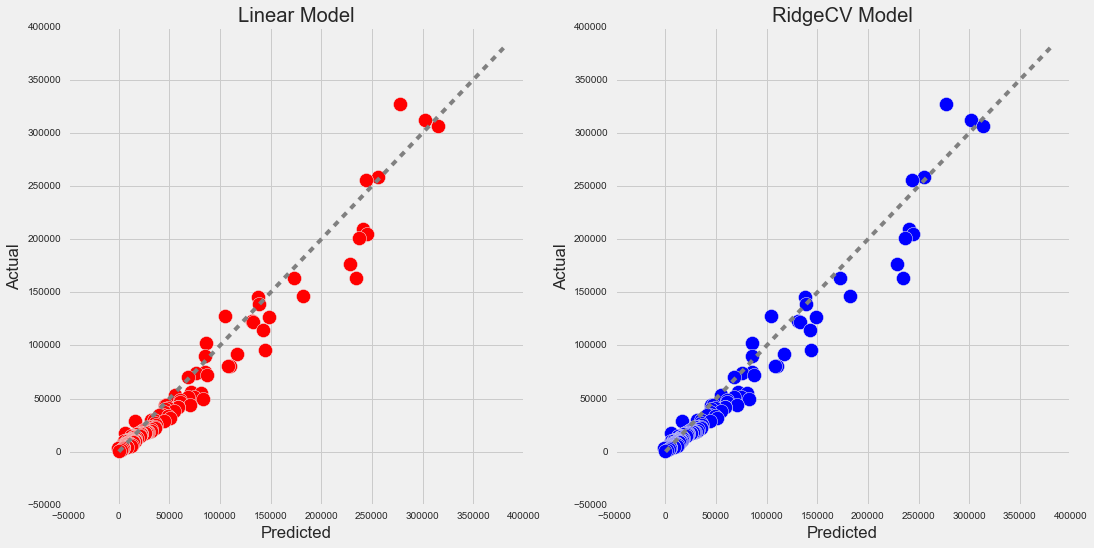

In [607]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dfp_piv[('sum', 'Sale (Dollars)')], c='red', s = 200)
axes[0].plot([0, 380000], [0, 380000], ls="--", c='gray')

axes[1].scatter(pred_rcv, dfp_piv[('sum', 'Sale (Dollars)')], c='b', s = 200)
axes[1].plot([0, 380000], [0, 380000], ls="--", c='gray')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.savefig('reg_15Q1_pred_16Q1_polk.png');

#### Comments:

Linear regression, as a model, performed slightly better in Polk than in Winneshiek. R^2 values increased to over 0.95. We also see that RidgeCV improved on the RMSE of the model by penalizing the coefficients quite significantly, in particular Median Bottle Cost, Median Bottle Price and Median Bottle Profit.

RidgeCV was conducted with 10 fold cross validation and chosen alpha was 0.2, with a minor reduction in RMSE from \$14,800 to \$14,737.

Similar to the conclusion above, using a linear regression model on this may not be the most ideal since categorical features couldn't be used as inputs into a linear regression model.

## Location recommendations:

In [609]:
# Scaling each column with minmax scaler to show percentile of Winneshiek's performance for each category

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
median_scaled = min_max_scaler.fit_transform(median_county.iloc[:,1:])
median_scaled = pd.DataFrame(median_scaled)
median_scaled1 = pd.concat([median_county.iloc[:,:1], median_scaled], axis = 1)


In [610]:
median_scaled1.columns = median_county.columns
median_scaled1.head(1)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
0,Winneshiek,0.022643,0.022682,0.021833,1.0,1.0,1.0,0.969072,0.970672,0.680551,0.023952,0.031458,0.469087,0.008563,0.317568,0.267415,0.035773


In [611]:
median_county.head(1)

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
0,Winneshiek,1284923.04,430029.68,92729,282036.82,94620.93,21382.0,15.55,5.194626,2352.0,5,10610,8.739774,7682,569.0,113.8,1536.4


In [612]:
median_scaled1[median_scaled1['County'] == 'Polk']

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
47,Polk,1.0,1.0,1.0,0.202997,0.202069,0.303966,0.544101,0.54045,0.216881,1.0,1.0,0.842422,0.028893,0.346284,0.0,0.0


In [613]:
median_county[median_county['County'] == 'Polk']

,County,Sum Sale,Sum Profit,Sum Bottles Sold,Median Sale,Median Profit,Median Bottles Sold,Median Bottle Price,Median Bottle Profit,Median No. Trans,No. of stores,No. of trans,Mean bottles per trans,Population,Area,Area per store,Population per store
47,Polk,55710484.38,18612680.69,4134606,74632.925,24937.28,8026.5,13.695,4.569838,871.5,168,331769,12.462304,16355,586.0,3.488095,97.35119


1 Winneshiek County - Ideal for second store expansion
   - Top average sale per store
   - Top average bottle sold per store
   - 97th percentile for average bottle price
   - 97th percentile for average bottle profit
   - 68th percentile for average number of transactions per store
   - 46th percentile for mean bottles per transaction


2 Polk County - Ideal for large stores (\$9mil revenue per year)
   - Top total sale, i.e. largest market
   - Top average bottle sold per store
   - Top total transaction
   - 54th percentile for average bottle price and average bottle profit


In [614]:
dfw = df_15[df_15['County'] == "Winneshiek"]

dfw_piv = pd.pivot_table(dfw, \
                         index = ['Store Number'], \
                         aggfunc = [np.mean, \
                                    sum \
                                   ] \
                         )
dfw_piv.reset_index(inplace=True)

dfw_piv.head()

Store Number                mean                                  \
               Bottle Gross Profit Bottle Volume (ml) Bottles Sold   
0         3721            5.222421        1210.516847    10.522408   
1         3819            5.272898        1003.634964     7.315087   
2         4183            5.194626        1035.873724     9.306122   
3         4762            4.794892        1161.832061     5.326162   
4         4818            4.362843         951.672640    11.489845   

                                                                         \
       Category County Number Gross Profit   Item Number Sale (Dollars)   
0  1.046358e+06          96.0    51.889784  44380.546287     155.148531   
1  1.057518e+06          96.0    32.371170  44868.867602      96.488820   
2  1.042999e+06          96.0    44.449511  44702.133503     132.851212   
3  1.045203e+06          96.0    25.860458  42798.115892      77.374552   
4  1.042030e+06          96.0    41.781971  37472.350060     125.011207   

                ...             sum                                      \
  Sale Month    ...     Item Number Sale (Dollars) Sale Month Sale Year   
0   6.814197    ...       135671330      474289.06      20831   6159855   
1   6.812179    ...       131151700      282036.82      19912   5889845   
2   6.583759    ...       105139418      312466.05      15485   4739280   
3   6.445524    ...        61672085      111496.73       9288   2903615   
4   6.712067    ...        31364357      104634.38       5618   1686555   

                                                                             \
  State Bottle Cost State Bottle Retail Vendor Number Volume Sold (Gallons)   
0          31772.24            47737.18        752534               9438.65   
1          30706.16            46118.84        768708               5933.84   
2          24361.92            36579.68        607977               5956.18   
3          13764.67            20674.11        357023               2401.72   
4           7275.63            10927.33        185153               2090.73   

                                   
  Volume Sold (Liters)   Zip Code  
0             35728.95  159272757  
1             22461.23  152291223  
2             22548.13  122541552  
3              9102.96   75139504  
4              7913.27   43608537  

[5 rows x 33 columns]

In [615]:
# Winneshiek price per bottle upper and lower bound

wpl = np.median(dfw_piv[('mean', 'State Bottle Retail')]) - (0.25 * dfw_piv[('mean', 'State Bottle Retail')].std())
wpu = np.median(dfw_piv[('mean', 'State Bottle Retail')]) + (0.25 * dfw_piv[('mean', 'State Bottle Retail')].std())

In [616]:
# Winneshiek annual bottle sold upper and lower bound

wbl = np.median(dfw_piv[('sum', 'Bottles Sold')]) - (0.25 * dfw_piv[('sum', 'Bottles Sold')].std())
wbu = np.median(dfw_piv[('sum', 'Bottles Sold')]) + (0.25 * dfw_piv[('sum', 'Bottles Sold')].std())

In [617]:
dfpo = df_15[df_15['Store Number'].apply(lambda x: True if x in out_list else False)]

dfpo_piv = pd.pivot_table(dfpo, \
                         index = ['Store Number'], \
                         aggfunc = [np.mean, \
                                    sum \
                                   ] \
                         )
dfpo_piv.reset_index(inplace=True)

dfpo_piv.head()

Store Number                mean                                  \
               Bottle Gross Profit Bottle Volume (ml) Bottles Sold   
0         2633            6.147339         918.359135    30.510816   
1         3420            6.324379        1100.016051    61.850401   
2         4829            6.314526         912.121129    28.558094   

                                                                         \
       Category County Number Gross Profit   Item Number Sale (Dollars)   
0  1.045309e+06          77.0   168.245862  60986.844013     504.377336   
1  1.044090e+06          77.0   367.225653  44953.137721    1098.668234   
2  1.044543e+06          77.0   160.127202  53683.322809     480.055969   

                ...             sum                                      \
  Sale Month    ...     Item Number Sale (Dollars) Sale Month Sale Year   
0   6.613646    ...      1189731353     9839393.08     129019  39308620   
1   6.757945    ...       140029024     3422351.55      21051   6276725   
2   6.456567    ...       977680675     8742779.31     117587  36697180   

                                                                             \
  State Bottle Cost State Bottle Retail Vendor Number Volume Sold (Gallons)   
0         239277.90           359200.19       5038264              153987.1   
1          39313.55            59013.99        817837               62709.1   
2         229628.70           344628.84       4702056              132710.0   

                                   
  Volume Sold (Liters)   Zip Code  
0            582860.61  981642560  
1            237374.50  156718765  
2            502306.92  916318568  

[3 rows x 33 columns]

In [618]:
# Polk price per bottle upper and lower bound

ppl = np.median(dfpo_piv[('mean', 'State Bottle Retail')]) - (0.25 * dfpo_piv[('mean', 'State Bottle Retail')].std())
ppu = np.median(dfpo_piv[('mean', 'State Bottle Retail')]) + (0.25 * dfpo_piv[('mean', 'State Bottle Retail')].std())

In [619]:
# Polk annual bottle sold upper and lower bound

pbl = np.median(dfpo_piv[('sum', 'Bottles Sold')]) - (0.25 * dfpo_piv[('sum', 'Bottles Sold')].std())
pbu = np.median(dfpo_piv[('sum', 'Bottles Sold')]) + (0.25 * dfpo_piv[('sum', 'Bottles Sold')].std())

In [620]:
# Recommendation for average bottle price and bottle sold for Winneshiek

print "Winneshiek recommended average price per bottle:"
print "Upper Bound =", round(wpu, 2)
print "Lower Bound =", round(wpl, 2)
print
print "Winneshiek recommended annual target bottle sold:"
print "Upper Bound =", round(wbu)
print "Lower Bound =", round(wbl)


Winneshiek recommended average price per bottle:
Upper Bound = 15.84
Lower Bound = 15.26

Winneshiek recommended annual target bottle sold:
Upper Bound = 23890.0
Lower Bound = 18874.0


In [621]:
# Recommendation for average bottle price and bottle sold for Winneshiek

print "Polk recommended average price per bottle:"
print "Upper Bound =", round(ppu, 2)
print "Lower Bound =", round(ppl, 2)
print
print "Polk recommended annual target bottle sold:"
print "Upper Bound =", round(pbu)
print "Lower Bound =", round(pbl)


Polk recommended average price per bottle:
Upper Bound = 19.0
Lower Bound = 18.85

Polk recommended annual target bottle sold:
Upper Bound = 573612.0
Lower Bound = 466588.0


#### Comments:

Recommended targets for annual bottle sold and average price per bottle were derived using average corresponding values from Winneshiek and Polk respectively. However, for Polk, we assumed client wants to launch a big store and hence used only outlier data points instead.

Ranges were given using median values in each county +/- 0.25 standard deviation, which put the targets inside 25th to 75th percentiles within each county

## Project conclusion

In this project, we looked at liquor store data from the state of IOWA is 2015 and 2016 Q1. We were tasked with the following:

   - Identify suitable locations for a liquor store owner's expansion plans
   - Create a model to predict future sales
   - Recommend target for bottles sold and average bottle price

After cleaning the data, county demographic data (dated 2010) were used to supplement the existing dataset in search of a richer analysis. However, without detailed demographic data (such as age groups, gender, income range, etc), using simple land area per store and population per store yielded little value.

1) Location recommendation

We examined all 99 counties across the state of IOWA and selected 2 counties as possible locations depending on the client's requirement.

For a typical store expansion plan (annual revenue of ~ \$200k), Winneshiek was recommended for the following reasons:
   - Top county for average sale per store
   - Top county for average bottle sold per store
   - 97th percentile for average bottle price
   - 97th percentile for average bottle profit
   - 68th percentile for average number of transactions per store
   - 46th percentile for mean bottles per transaction
   - Recommended average price per bottle ~ \$15.50
   - Recommended annual bottles sold ~ 21,000 bottles
   
For a large scale expansion (annual revenue of ~ \$9mil per store), which requires access to a large market base, we recommended Polk County for the following reasons:

   - Top county for total sales, i.e. largest market
   - Top county for total bottle sold per store
   - Top county for total number of transactions
   - 54th percentile for average bottle price and average bottle profit
   - Recommended average price per bottle ~ \$19
   - Recommended annual bottle sold ~ 500,000 bottles

2) Predictive modelling using linear regression

Predictive models were created for both the approaches to locations. Models were created using historical per store data from the respective counties using the following features:

   - Median Bottle Cost per store
   - Median Bottle Price per store
   - Median Bottle Profit per store
   - Sum Bottles sold per store
   - Sum Volume sold per store
   - No. of transactions per store

2015 Q1 data was used as the training set and 2016 Q1 data was used as the test set. Ridge regularization and cross-validation were conducted as part of the fitting process. Alpha chosen by Ridge algorithm was 0.2 for regularization and was minimally effective in reducing RMSE. Model performance was considered mediocre with high r^2 (~ 0.95) but relatively high Root Mean Squared Error. Coefficients of the models were also significant.

Suggestions to improve the model include:

   - Scaling the features
   - Use of richer dataset for advanced feature engineering, such as the aforementioned demographics data
   - Using logistical regression to take into account locations of individual stores within the county
   - Include more historical data for time-series analyses of market trends over the years

In conclusion, this a much more complex project which involves heavy data munging and dataframe manipulations. Predictive modelling was limited in scope, primary due to the restriction to linear regression. 
